In [ ]:
from collections import OrderedDict
from google.colab import drive
import matplotlib
matplotlib.rcParams['figure.figsize'] = [5, 4]
matplotlib.rcParams['font.size'] = 10
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.autograd import grad, Variable
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset

In [ ]:
!pip install pylogit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 1.4 MB/s eta 0:00:00


**Note:** The `pylogit` library needs to be installed manually for Colab. To solve the error `cannot import name 'Iterable' from 'collections' (/usr/lib/python3.10/collections/__init__.py)`, we can replace `collections` with `collections.abc` in the file `/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py`.

In [ ]:
file_path = '/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py'
with open(file_path, 'r') as file:
    lines = file.readlines()

lines[14] = 'from collections.abc import Iterable\n'

with open(file_path, 'w') as file:
    file.writelines(lines)

In [ ]:
import pylogit as pl

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# CMAP Dataset

## Data import

In [ ]:
size = 10000
var, alt = 'auto_cost', 0
path = '/content/drive/My Drive'
data1 = pd.read_csv(f'{path}/CMAP/chicago_processed.csv', index_col=0).sample(size, random_state=3)

In [ ]:
data1['high_edu'] = data1['educ'].isin([5, 6]).astype(int)
data1['hhveh_1'] = (data1['hhveh'] == 1).astype(int)
data1['hhsize_1'] = (data1['hhsize'] == 1).astype(int)
data1['high_inc'] = (data1['hhinc'] > 7).astype(int)

data1 = data1[['age', 'male', 'high_edu', 'hhsize_1', 'hhsize', 'hhveh', 'hhveh_1', 'high_inc', 'auto_time', 'auto_cost', 'train_time',
               'train_cost', 'active_time', 'mode']]

In [ ]:
data = pd.DataFrame(StandardScaler().fit_transform(data1), columns=data1.columns, index=data1.index)
data['mode'] = data1['mode']

In [ ]:
train_size = int(size*.7)
val_size = int(size*.1)
test_size = size - train_size - val_size

data_train, data_remain = data[:train_size], data[train_size:]
data_val, data_test = data_remain[:val_size], data_remain[val_size:]

## Data processing
2. Build a dataframe with average values, except for the visualized variable,
3. Develop a function to build dataframes for model regularity calculation, and
4. Load the data for training, validation, and testing.

In [ ]:
upper, lower = data[var].max(), data[var].min()
prb_size = 201
data_prb = pd.DataFrame(np.zeros((prb_size, len(data.columns))), columns=data.columns)
data_prb[var] = np.linspace(lower, upper, prb_size)

In [ ]:
num_var = data.columns.get_loc(var)

def gen_reg_df(data, upper, lower):
    'Function to build a dataset for regularity calculation'
    data_reg = data.copy()
    data_reg = data_reg.loc[data_reg.index.repeat(2)]
    data_reg.iloc[np.arange(1, len(data_reg), 2), num_var] += (upper - lower) / 200
    return data_reg

In [ ]:
class Load(Dataset):
    'Class to load the datasets for modeling'
    def __init__(self, data):
        x_set = data.drop(columns='mode')
        y_set = data['mode']
        self.X = Variable(torch.tensor(x_set.values).float(), requires_grad=True)
        self.y = torch.tensor(y_set.values)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(Load(data_train), batch_size=train_size//10, worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(Load(data_val), batch_size=val_size, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(Load(data_test), batch_size=test_size, worker_init_fn=seed_worker, generator=g)

# Datasets for model analysis
prb_loader = DataLoader(Load(data_prb), batch_size=prb_size, worker_init_fn=seed_worker, generator=g)
train_reg_loader = DataLoader(Load(gen_reg_df(data_train, upper, lower)), batch_size=2*train_size, worker_init_fn=seed_worker, generator=g)
val_reg_loader = DataLoader(Load(gen_reg_df(data_val, upper, lower)), batch_size=2*val_size, worker_init_fn=seed_worker, generator=g)
test_reg_loader = DataLoader(Load(gen_reg_df(data_test, upper, lower)), batch_size=2*test_size, worker_init_fn=seed_worker, generator=g)

## True market shares

In [ ]:
l_alt = ['Auto', 'Train', 'Active']

def true_share(df):
    'Function to calculate the true market shares'
    y = df['mode'].replace(0, l_alt[0]).replace(1, l_alt[1]).replace(2, l_alt[2])
    return y.value_counts(normalize=True).round(3)[l_alt]

In [ ]:
# Training set
true_share(data_train)

mode
Auto      0.693
Train     0.100
Active    0.207
Name: proportion, dtype: float64

In [ ]:
# Validation set
true_share(data_val)

mode
Auto      0.697
Train     0.089
Active    0.214
Name: proportion, dtype: float64

In [ ]:
# Test set
true_share(data_test)

mode
Auto      0.678
Train     0.106
Active    0.216
Name: proportion, dtype: float64

# Random utility models (RUMs)
The RUMs are estimated based on unstandardized inputs and a data frame with wide format.

In [ ]:
def convert(df):
    'Function for data format conversion'
    df = df.reset_index(names='obs_id', drop=True)
    for a in ['auto', 'train', 'active']:
        df[f'ava_{a}'] = 1
    # Individual-specific variables
    ind_vars = df.columns.tolist()[:8]
    # Alternative-specific variables
    alt_vars = {u'time': dict([(0, 'auto_time'), (1, 'train_time'), (2, 'active_time')]),
                u'cost': dict([(0, 'auto_cost'), (1, 'train_cost')])}
    # Availability variables
    ava_vars = {0: 'ava_auto', 1: 'ava_train', 2: 'ava_active'}
    # Observation ID column
    df['obs_id'] = np.arange(df.shape[0], dtype=int) + 1
    # Wide format -> long format
    df_lg = pl.convert_wide_to_long(df, ind_vars, alt_vars, ava_vars, 'obs_id', 'mode', 'alt_id')
    return df_lg

In [ ]:
data1_train, data1_remain = data1[:train_size], data1[train_size:]
data1_val, data1_test = data1_remain[:val_size], data1_remain[val_size:]

In [ ]:
data1_train_lg = convert(data1_train)
data1_train_lg

obs_id  alt_id  mode  age  male  high_edu  hhsize_1  hhsize  hhveh  \
0           1       0     1   39     0         0         0       3      2   
1           1       1     0   39     0         0         0       3      2   
2           1       2     0   39     0         0         0       3      2   
3           2       0     1   29     0         1         0       2      2   
4           2       1     0   29     0         1         0       2      2   
...       ...     ...   ...  ...   ...       ...       ...     ...    ...   
20995    6999       1     0   38     0         1         0       6      2   
20996    6999       2     0   38     0         1         0       6      2   
20997    7000       0     1   48     1         1         0       2      2   
20998    7000       1     0   48     1         1         0       2      2   
20999    7000       2     0   48     1         1         0       2      2   

       hhveh_1  high_inc        time      cost  
0            0         1    7.800000  5.844000  
1            0         1   55.183333  2.550000  
2            0         1   34.941667  0.000000  
3            0         0    4.200000  6.572333  
4            0         0   12.450000  2.408333  
...        ...       ...         ...       ...  
20995        0         1   74.033333  3.250000  
20996        0         1  157.900000  0.000000  
20997        0         1   10.716667  5.006333  
20998        0         1   27.600000  2.608333  
20999        0         1   20.058333  0.000000  

[21000 rows x 13 columns]

## Multinomial logit (MNL)
Auto is set as the reference alternative for sociodemographics.

In [ ]:
spec = OrderedDict()
name = OrderedDict()

# Alternative-specific constants
spec['intercept'] = [1, 2]
name['intercept'] = ['asc_train', 'asc_active']

# Individual-specific variables
spec['age'] = [1, 2]
name['age'] = ['age_train', 'age_active']
spec['male'] = [1, 2]
name['male'] = ['male_train', 'male_active']
spec['high_edu'] = [1, 2]
name['high_edu'] = ['high_edu_train', 'high_edu_active']
spec['hhsize'] = [1, 2]
name['hhsize'] = ['hhsize_train', 'hhsize_active']
spec['hhsize_1'] = [1, 2]
name['hhsize_1'] = ['hhsize_1_train', 'hhsize_1_active']
spec['hhveh'] = [1, 2]
name['hhveh'] = ['hhveh_train', 'hhveh_active']
spec['hhveh_1'] = [1, 2]
name['hhveh_1'] = ['hhveh_1_train', 'hhveh_1_active']
spec['high_inc'] = [1, 2]
name['high_inc'] = ['high_inc_train', 'high_inc_active']

# Alternative-specific variables
spec['time'] = [0, 1, 2]
name['time'] = ['time_auto', 'time_train', 'time_active']
spec['cost'] = [0, 1]
name['cost'] = ['cost_auto', 'cost_train']

In [ ]:
mnl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode', specification=spec,
                             model_type='MNL', names=name)
mnl.fit_mle(np.zeros(23))
mnl.get_statsmodels_summary()

Log-likelihood at zero: -7,690.2860
Initial Log-likelihood: -7,690.2860


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


Estimation Time for Point Estimation: 0.45 seconds.
Final log-likelihood: -4,710.2074


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                        mode   No. Observations:                7,000
Model:             Multinomial Logit Model   Df Residuals:                    6,977
Method:                                MLE   Df Model:                           23
Date:                     Sun, 07 Apr 2024   Pseudo R-squ.:                   0.388
Time:                             18:09:57   Pseudo R-bar-squ.:               0.385
AIC:                             9,466.415   Log-Likelihood:             -4,710.207
BIC:                             9,624.049   LL-Null:                    -7,690.286
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
asc_train           0.1240      0.392      0.317      0.752      -0.644       0.892
asc_active         -0.3050      0.191     -1.597      0.110      -0.679       0.069
age_train          -0.0168      0.004     -4.646      0.000      -0.024      -0.010
age_active         -0.0157      0.003     -5.716      0.000      -0.021      -0.010
male_train          0.5913      0.088      6.711      0.000       0.419       0.764
male_active         0.5713      0.068      8.459      0.000       0.439       0.704
high_edu_train      0.4762      0.115      4.126      0.000       0.250       0.702
high_edu_active     0.5420      0.086      6.299      0.000       0.373       0.711
hhsize_train       -0.1501      0.052     -2.896      0.004      -0.252      -0.049
hhsize_active      -0.1785      0.041     -4.352      0.000      -0.259      -0.098
hhsize_1_train     -0.2433      0.136     -1.784      0.074      -0.511       0.024
hhsize_1_active    -0.2203      0.104     -2.121      0.034      -0.424      -0.017
hhveh_train        -0.6850      0.062    -11.089      0.000      -0.806      -0.564
hhveh_active       -0.8409      0.049    -17.084      0.000      -0.937      -0.744
hhveh_1_train      -0.5685      0.092     -6.175      0.000      -0.749      -0.388
hhveh_1_active     -0.3302      0.069     -4.796      0.000      -0.465      -0.195
high_inc_train      0.5887      0.113      5.222      0.000       0.368       0.810
high_inc_active     0.3336      0.083      4.020      0.000       0.171       0.496
time_auto          -0.0637      0.007     -8.564      0.000      -0.078      -0.049
time_train         -0.0364      0.003    -13.543      0.000      -0.042      -0.031
time_active        -0.0338      0.002    -21.773      0.000      -0.037      -0.031
cost_auto          -0.1793      0.017    -10.349      0.000      -0.213      -0.145
cost_train         -0.6884      0.157     -4.380      0.000      -0.996      -0.380
===================================================================================
"""

## Mixed logit (MXL)

In [ ]:
# mix_var = ['time_auto', 'time_train', 'time_active', 'cost_auto', 'cost_train']

# mxl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode', specification=spec,
#                              model_type='Mixed Logit', names=name, mixing_id_col='obs_id', mixing_vars=mix_var)
# mxl.fit_mle(np.zeros(28), num_draws=100, seed=13)
# mxl.get_statsmodels_summary()

## Results

In [ ]:
data1_val_lg = convert(data1_val)
data1_test_lg = convert(data1_test)

In [ ]:
def dcm_performance(pred, df):
    'Function to calculate performance metrics for DCMs'
    prb = pred.reshape(len(df), 3)
    y = df['mode']
    y_pred = prb.argmax(1)
    ll = 0
    for i in range(len(df)):
        ll += np.log(prb[i, y.iloc[i]])
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    return [ll, acc, f1]

In [ ]:
def print_metrics(met_train, met_val, met_test):
    'Function to print performance metrics'
    print(f'Training set:   LL = {met_train[0]:<7.1f} | acc = {met_train[1]:.1%} | F1 = {met_train[2]:.1%}')
    print(f'Validation set: LL = {met_val[0]:<7.1f} | acc = {met_val[1]:.1%} | F1 = {met_val[2]:.1%}')
    print(f'Test set:       LL = {met_test[0]:<7.1f} | acc = {met_test[1]:.1%} | F1 = {met_test[2]:.1%}')

In [ ]:
# MNL model
met_train_mnl = dcm_performance(mnl.predict(data1_train_lg), data1_train)
met_val_mnl = dcm_performance(mnl.predict(data1_val_lg), data1_val)
met_test_mnl = dcm_performance(mnl.predict(data1_test_lg), data1_test)
print_metrics(met_train_mnl, met_val_mnl, met_test_mnl)

Training set:   LL = -4710.2 | acc = 73.1% | F1 = 68.1%
Validation set: LL = -693.8  | acc = 73.7% | F1 = 69.0%
Test set:       LL = -1426.3 | acc = 71.9% | F1 = 66.9%


In [ ]:
# MXL model
# met_train_mxl = dcm_performance(mxl.predict(data1_train_lg, num_draws=500, seed=13), data1_train)
# met_val_mxl = dcm_performance(mxl.predict(data1_val_lg, num_draws=500, seed=13), data1_val)
# met_test_mxl = dcm_performance(mxl.predict(data1_test_lg, num_draws=500, seed=13), data1_test)
# print_metrics(met_train_mxl, met_val_mxl, met_test_mxl)

In [ ]:
upper1, lower1 = data1[var].max(), data1[var].min()
data1_prb = pd.DataFrame(np.tile(data1.mean(), (prb_size, 1)), columns=data1.columns)
data1_prb['mode'] = pd.Series([np.random.randint(0, 3) for i in range(prb_size)])
data1_prb[var] = np.linspace(lower1, upper1, prb_size)
data1_prb_lg = convert(data1_prb)

In [ ]:
# A colorblind-friendly colormap
l_color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

def RUM_sub(l_prb, name):
    'Function to plot substitution patterns'
    for a in range(3):
        plt.plot(data1_prb[var], l_prb[:, a], color=l_color[a], label=l_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} ($)')
    plt.ylabel('Probability')
    plt.show()
    # plt.savefig(f'{path}/Regularity_results/{name}_10K.png', bbox_inches='tight', dpi=200)

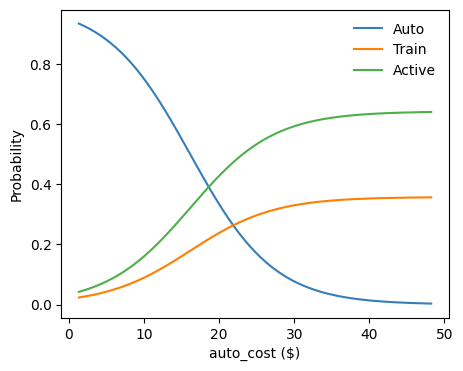

In [ ]:
# MNL model
l_prb_MNL = mnl.predict(data1_prb_lg).reshape(len(data1_prb), 3)
RUM_sub(l_prb_MNL, 'MNL')

In [ ]:
# MXL model
# l_prb_MXL = mxl.predict(data1_prb_lg, num_draws=500, seed=13).reshape(len(data1_prb), 3)
# RUM_sub(l_prb_MXL, 'MXL')

In [ ]:
data1_train_reg = gen_reg_df(data1_train, upper1, lower1)
data1_val_reg = gen_reg_df(data1_val, upper1, lower1)
data1_test_reg = gen_reg_df(data1_test, upper1, lower1)

data1_train_reg_lg = convert(data1_train_reg)
data1_val_reg_lg = convert(data1_val_reg)
data1_test_reg_lg = convert(data1_test_reg)

In [ ]:
eps = (lower1 - upper1) / 1e6

def cal_reg(l_prb_reg):
    'Function to calculate strong and weak regularities'
    diff = np.subtract(l_prb_reg[1::2], l_prb_reg[::2])
    reg_st = sum(diff < eps) / len(diff)
    reg_wk = sum(diff < -eps) / len(diff)
    print(f'Strong regularity = {reg_st:.3f}')
    print(f'Weak regularity   = {reg_wk:.3f}')
    return [reg_st, reg_wk]

In [ ]:
# MNL model
print('Training set:')
prb_reg = mnl.predict(data1_train_reg_lg).reshape(2*train_size, 3)[:, alt]
met_train_mnl.extend(cal_reg(prb_reg))

print('-'*30, '\nValidation set:')
prb_reg = mnl.predict(data1_val_reg_lg).reshape(2*val_size, 3)[:, alt]
met_val_mnl.extend(cal_reg(prb_reg))

print('-'*30, '\nTest set:')
prb_reg = mnl.predict(data1_test_reg_lg).reshape(2*test_size, 3)[:, alt]
met_test_mnl.extend(cal_reg(prb_reg))

Training set:
Strong regularity = 0.998
Weak regularity   = 1.000
------------------------------ 
Validation set:
Strong regularity = 1.000
Weak regularity   = 1.000
------------------------------ 
Test set:
Strong regularity = 0.998
Weak regularity   = 1.000


In [ ]:
# MXL model
# print('Training set:')
# prb_reg = mxl.predict(data1_train_reg_lg, num_draws=500, seed=13).reshape(2*train_size, 3)[:, alt]
# met_train_mxl.extend(cal_reg(prb_reg))

# print('-'*30, '\nValidation set:')
# prb_reg = mxl.predict(data1_val_reg_lg, num_draws=500, seed=13).reshape(2*val_size, 3)[:, alt]
# met_val_mxl.extend(cal_reg(prb_reg))

# print('-'*30, '\nTest set:')
# prb_reg = mxl.predict(data1_test_reg_lg, num_draws=500, seed=13).reshape(2*test_size, 3)[:, alt]
# met_test_mxl.extend(cal_reg(prb_reg))

In [ ]:
l_index = ['Log-likelihood', 'Accuracy', 'F1 score', 'Strong regularity', 'Weak regularity']

# results_train = pd.DataFrame({'MNL': met_train_mnl, 'MXL': met_train_mxl}, index=l_index)
# results_val = pd.DataFrame({'MNL': met_val_mnl, 'MXL': met_val_mxl}, index=l_index)
# results_test = pd.DataFrame({'MNL': met_test_mnl, 'MXL': met_test_mxl}, index=l_index)

results_train = pd.DataFrame({'MNL': met_train_mnl}, index=l_index)
results_val = pd.DataFrame({'MNL': met_val_mnl}, index=l_index)
results_test = pd.DataFrame({'MNL': met_test_mnl}, index=l_index)

results_train_std = pd.DataFrame({'MNL': 0}, index=l_index)
results_val_std = pd.DataFrame({'MNL': 0}, index=l_index)
results_test_std = pd.DataFrame({'MNL': 0}, index=l_index)

# Neural networks (NNs)

## Model structure

In [ ]:
def cal_loss(model, X, y, GR, base, lambd, criterion):
    '''
    Function to regularize the loss function
    lambd: weight of GR -> (1-lambd) is the weight of loss
    base: indicator of regularizing the sum
    '''
    loss = criterion(model(X), y)
    # Utility GR
    if GR == 'UGR':
        utl = model(X)
        g1 = grad(utl[:, 0], X, torch.ones_like(utl[:, 0]), create_graph=True)[0][:, 8:10]
        g2 = grad(utl[:, 1], X, torch.ones_like(utl[:, 1]), create_graph=True)[0][:, 10:12]
        g3 = grad(utl[:, 2], X, torch.ones_like(utl[:, 2]), create_graph=True)[0][:, 12]
    # Probability GR
    elif GR == 'PGR':
        prb = softmax(model(X), dim=1)
        g1 = grad(prb[:, 0], X, torch.ones_like(prb[:, 0]), create_graph=True)[0][:, 8:10]
        g2 = grad(prb[:, 1], X, torch.ones_like(prb[:, 1]), create_graph=True)[0][:, 10:12]
        g3 = grad(prb[:, 2], X, torch.ones_like(prb[:, 2]), create_graph=True)[0][:, 12]
    # Loss GR
    elif GR == 'LGR':
        log_prb = torch.log(softmax(model(X), dim=1))
        g1 = grad(log_prb[:, 0]*(y==0), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 8:10]
        g2 = grad(log_prb[:, 1]*(y==1), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 10:12]
        g3 = grad(log_prb[:, 2]*(y==2), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 12]
    # Without GR
    else:
        return loss

    # Sum- vs. norm-GR
    if base == 'sum':
        reg = g1[g1 > 0].sum() + g2[g2 > 0].sum() + g3[g3 > 0].sum()
    else:
        reg = torch.pow(g1, 2).sum() + torch.pow(g2, 2).sum() + torch.pow(g3, 2).sum()
    return loss + lambd * reg

In [ ]:
def train_loop(model, GR, base, lambd, optimizer, criterion):
    'Function for DNN training in each epoch'
    for X, y in train_loader:
        loss = cal_loss(model, X, y, GR, base, lambd, criterion)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [ ]:
def cal_metrics(model, criterion, loader):
    ll = 0
    y_true, y_pred = [], []
    for X, y in loader:
        pred = model(X)
        y_true.extend(y)
        loss = criterion(pred, y).item()
        ll -= loss * len(X)
        y_pred.extend(pred.argmax(1))
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    return ll, acc, f1, loss

In [ ]:
def test(model, criterion):
    'Function for NN testing'
    model.eval()
    with torch.no_grad():
        # For loss, accuracy, and F1 score calculation
        met_train = cal_metrics(model, criterion, train_loader)
        met_val = cal_metrics(model, criterion, val_loader)
        met_test = cal_metrics(model, criterion, test_loader)

        # For probability calculation
        for X, _ in prb_loader:
            prb = softmax(model(X), dim=1).detach().numpy()

        # For regularity calculation
        for X_train, _ in train_reg_loader:
            prb_reg_train = softmax(model(X_train), dim=1)[:, alt].detach().numpy()
        for X_val, _ in val_reg_loader:
            prb_reg_val = softmax(model(X_val), dim=1)[:, alt].detach().numpy()
        for X_test, _ in test_reg_loader:
            prb_reg_test = softmax(model(X_test), dim=1)[:, alt].detach().numpy()
    return met_train, met_val, met_test, prb, prb_reg_train, prb_reg_val, prb_reg_test

In [ ]:
def plot_loss(agg_loss):
    'Function to plot training and validation losses per epoch'
    for l_loss in agg_loss:
        plt.plot(range(1, len(l_loss[0])+1), l_loss[0], color=l_color[0], alpha=.2)
        plt.plot(range(1, len(l_loss[1])+1), l_loss[1], color=l_color[1], alpha=.2)
    plt.xlabel('Epoch')
    plt.ylabel('Cross-entropy loss')
    plt.show()

In [ ]:
num_models = 10

def train(NN, num_epochs, GR, base, lambd):
    'Function for NN training'
    agg_loss, l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = [[] for i in range(8)]
    for m in range(1, num_models+1):
        torch.manual_seed(m)
        model = NN()
        l_loss_train_epoch, l_loss_val_epoch = [], []
        optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0)
        criterion = nn.CrossEntropyLoss()
        for i in range(num_epochs):
            l_loss_train_epoch.append(train_loop(model, GR, base, lambd, optimizer, criterion).detach().numpy())
            model.eval()
            with torch.no_grad():
                l_loss_val_epoch.append(cal_metrics(model, criterion, val_loader)[3])
            model.train()
        agg_loss.append([l_loss_train_epoch, l_loss_val_epoch])
        met_train, met_val, met_test, prb, reg_train, reg_val, reg_test = test(model, criterion)
        [x.append(y) for x, y in zip([l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test],
                                     [met_train, met_val, met_test, prb, reg_train, reg_val, reg_test])]
        print(f'Model {m:<2}')
        print_metrics(met_train, met_val, met_test)
    plot_loss(agg_loss)
    return l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test

## Functions for analysis
We evaluate the models by:
- test loss, accuracy, and F1 score;
- strong and weak regularities.

In [ ]:
def NN_agg(l_met):
    'Function to analyze aggregate NN performance'
    # Averages
    avg_ll = np.mean([r[0] for r in l_met])
    avg_acc = np.mean([r[1] for r in l_met])
    avg_f1 = np.mean([r[2] for r in l_met])
    # Standard deviations
    std_ll = np.std([r[0] for r in l_met])
    std_acc = np.std([r[1] for r in l_met])
    std_f1 = np.std([r[2] for r in l_met])
    print(f'Average log-likelihood = {avg_ll:.1f} ({std_ll:.1f})')
    print(f'Average accuracy       = {avg_acc:.1%} ({std_acc:.1%})')
    print(f'Average F1 score       = {avg_f1:.1%} ({std_f1:.1%})')
    return [avg_ll, avg_acc, avg_f1], [std_ll, std_acc, std_f1]

In [ ]:
def NN_sub(l_prb, NN, base, GR, lambd):
    'Function to plot substitution patterns'
    for a in range(3):
        for p in l_prb[:, :, a]:
            plt.plot(data1_prb[var], p, color=l_color[a], alpha=.10)
        plt.plot(data1_prb[var], np.mean(l_prb[:, :, a], axis=0), color=l_color[a], label=l_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} ($)')
    plt.ylabel('Probability')
    if GR == 'none':
        plt.show()
    else:
        plt.savefig(f'{path}/Regularity_results/{NN.__name__}_{base}_{GR}_{lambd}_10K.png', bbox_inches='tight', dpi=200)
    plt.show()

In [ ]:
def NN_reg(l_prb_reg):
    'Function to calculate strong and weak regularities for NNs'
    l_st_reg, l_wk_reg = [], []
    for prb_reg in l_prb_reg:
        diff = np.subtract(prb_reg[1::2], prb_reg[::2])
        l_st_reg.append(sum(diff < eps) / len(diff))
        l_wk_reg.append(sum(diff < -eps) / len(diff))
    avg_st_reg = np.mean(l_st_reg)
    avg_wk_reg = np.mean(l_wk_reg)
    std_st_reg = np.std(l_st_reg)
    std_wk_reg = np.std(l_wk_reg)
    print(f'Strong regularity = {avg_st_reg:.3f} ({std_st_reg:.3f})')
    print(f'Weak regularity   = {avg_wk_reg:.3f} ({std_wk_reg:.3f})')
    return [avg_st_reg, avg_wk_reg], [std_st_reg, std_wk_reg]

In [ ]:
def comparison(lambdas, agg_ll, agg_acc, agg_f1, l_st_reg, l_wk_reg, NN, base, GR):
    'Function to compare NN models'
    print('-'*30, '\nModel comparison:')
    fig, ax1 = plt.subplots()

    # Plot average test log-likelihood
    ax1.grid(linestyle='--', color='lightgray')
    ax1.plot(np.log10(lambdas), agg_ll, marker='.', color=l_color[0], label='Log-likelihood')
    ax1.set_xlabel(r'$\lg(\lambda)$')
    ax1.set_ylabel('Test log-likelihood (average)')

    # Plot average test accuracy
    ax2 = ax1.twinx()
    ax2.plot(np.log10(lambdas), agg_acc, marker='.', color=l_color[1], label='Accuracy')
    ax2.set_ylabel(r'Test accuracy, $F_1$ score, regularities (average)')

    # Plot average test F1 score
    ax2.plot(np.log10(lambdas), agg_f1, marker='.', color=l_color[2], label=r'$F_1$ score')

    # Plot average regularities
    ax2.plot(np.log10(lambdas), l_st_reg, marker='.', linestyle='dashed', color=l_color[3], label='Strong regularity')
    ax2.plot(np.log10(lambdas), l_wk_reg, marker='.', linestyle='dashed', color=l_color[4], label='Weak regularity')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    box = ax1.get_position()
    ax1.legend(h1+h2, l1+l2, frameon=False, loc='upper center', bbox_to_anchor=(.5, -.15), ncol=2)
    fig.savefig(f'{path}/Regularity_results/{NN.__name__}_{base}_{GR}_10K.png', bbox_inches='tight', dpi=200)

In [ ]:
def result(NN, num_epochs, GR, lambdas=[0], base='sum'):
    'Function to display all DNN results'
    agg_ll_test, agg_acc_test, agg_f1_test, l_st_reg, l_wk_reg = [[] for i in range(5)]
    for lambd in lambdas:
        print(f'Penalty = {lambd}')
        print('-'*30)
        if NN == DNN and lambd > 1:
            l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = train(NN, num_epochs+20, GR, base, lambd)
        else:
            l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = train(NN, num_epochs, GR, base, lambd)
        # Average LL, accuracy, and F1 score
        print('-'*30, '\nTraining set:')
        avg_met_train, std_met_train = NN_agg(l_met_train)
        print('-'*30, '\nValidation set:')
        avg_met_val, std_met_val = NN_agg(l_met_val)
        print('-'*30, '\nTest set:')
        avg_met_test, std_met_test = NN_agg(l_met_test)
        [x.append(y) for x, y in zip([agg_ll_test, agg_acc_test, agg_f1_test], avg_met_test)]

        # Regularities
        if GR == 'none':
            name = f'{NN.__name__}'
        else:
            name = f'{NN.__name__}, {base}-{GR} ({lambd})'
        print('-'*30, '\nTraining set:')
        [x.extend(y) for x, y in zip([avg_met_train, std_met_train], NN_reg(l_prb_reg_train))]
        results_train[name] = avg_met_train
        results_train_std[name] = std_met_train
        print('-'*30, '\nValidation set:')
        [x.extend(y) for x, y in zip([avg_met_val, std_met_val], NN_reg(l_prb_reg_val))]
        results_val[name] = avg_met_val
        results_val_std[name] = std_met_val
        print('-'*30, '\nTest set:')
        avg_reg, std_reg = NN_reg(l_prb_reg_test)
        [x.extend(y) for x, y in zip([avg_met_test, std_met_test], [avg_reg, std_reg])]
        results_test[name] = avg_met_test
        results_test_std[name] = std_met_test
        [x.append(y) for x, y in zip([l_st_reg, l_wk_reg], avg_reg)]

        # Substitution pattern
        print('-'*30)
        NN_sub(np.array(l_prb), NN, base, GR, lambd)
    if len(lambdas) > 1:
        comparison(lambdas, agg_ll_test, agg_acc_test, agg_f1_test, l_st_reg, l_wk_reg, NN, base, GR)

## Deep neural networks (DNNs)

In [ ]:
class DNN(nn.Module):
    'Class of DNNs (4 hidden layers x 100 neurons)'
    def __init__(self):
        super(DNN, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(13, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 3)
        )

    def forward(self, x):
        return self.seq(x)

### Without GR

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -4267.3 | acc = 75.3% | F1 = 72.1%
Validation set: LL = -636.9  | acc = 74.3% | F1 = 71.0%
Test set:       LL = -1345.5 | acc = 72.8% | F1 = 69.2%
Model 2 
Training set:   LL = -4263.6 | acc = 74.9% | F1 = 71.8%
Validation set: LL = -630.5  | acc = 74.5% | F1 = 71.1%
Test set:       LL = -1349.0 | acc = 73.4% | F1 = 70.0%
Model 3 
Training set:   LL = -4274.8 | acc = 75.0% | F1 = 71.3%
Validation set: LL = -638.1  | acc = 73.6% | F1 = 69.4%
Test set:       LL = -1352.4 | acc = 72.9% | F1 = 68.8%
Model 4 
Training set:   LL = -4249.0 | acc = 75.5% | F1 = 72.5%
Validation set: LL = -635.0  | acc = 73.5% | F1 = 70.1%
Test set:       LL = -1346.1 | acc = 73.0% | F1 = 69.5%
Model 5 
Training set:   LL = -4265.7 | acc = 75.0% | F1 = 71.8%
Validation set: LL = -629.3  | acc = 73.6% | F1 = 70.1%
Test set:       LL = -1356.5 | acc = 73.2% | F1 = 69.7%
Model 6 
Training set:   LL = -4265.2 | acc = 75.5% | F1 = 72.3%
Validat

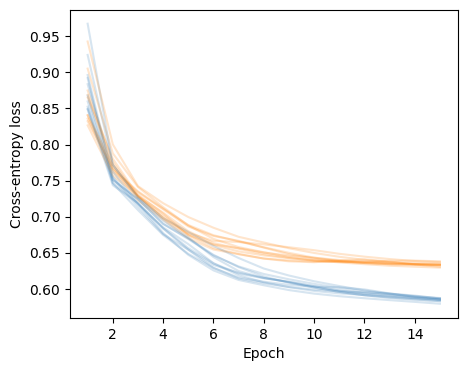

------------------------------ 
Training set:
Average log-likelihood = -4272.6 (13.2)
Average accuracy       = 75.2% (0.2%)
Average F1 score       = 71.7% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -633.5 (2.5)
Average accuracy       = 73.9% (0.4%)
Average F1 score       = 70.2% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1351.7 (4.8)
Average accuracy       = 72.9% (0.3%)
Average F1 score       = 69.1% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.889 (0.061)
Weak regularity   = 0.927 (0.058)
------------------------------ 
Validation set:
Strong regularity = 0.879 (0.057)
Weak regularity   = 0.928 (0.056)
------------------------------ 
Test set:
Strong regularity = 0.889 (0.066)
Weak regularity   = 0.922 (0.062)
------------------------------


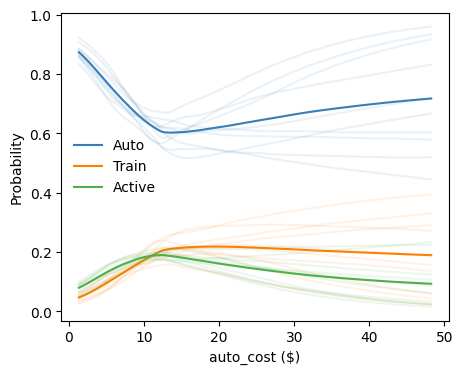

In [ ]:
result(DNN, 15, 'none')

### PGR

In [ ]:
# With sum
# result(DNN, 15, 'PGR', [10**i for i in range(2, -5, -1)])

Penalty = 100
------------------------------
Model 1 
Training set:   LL = -5011.5 | acc = 71.9% | F1 = 65.2%
Validation set: LL = -707.2  | acc = 70.8% | F1 = 64.2%
Test set:       LL = -1538.6 | acc = 69.7% | F1 = 62.6%
Model 2 
Training set:   LL = -5002.2 | acc = 71.8% | F1 = 65.0%
Validation set: LL = -708.9  | acc = 70.6% | F1 = 63.8%
Test set:       LL = -1535.9 | acc = 69.6% | F1 = 62.3%
Model 3 
Training set:   LL = -5064.1 | acc = 71.3% | F1 = 63.1%
Validation set: LL = -718.2  | acc = 70.3% | F1 = 62.0%
Test set:       LL = -1552.3 | acc = 69.2% | F1 = 60.6%
Model 4 
Training set:   LL = -5001.6 | acc = 72.0% | F1 = 65.4%
Validation set: LL = -706.7  | acc = 70.6% | F1 = 63.9%
Test set:       LL = -1531.4 | acc = 70.0% | F1 = 62.9%
Model 5 
Training set:   LL = -5051.5 | acc = 71.1% | F1 = 62.3%
Validation set: LL = -715.7  | acc = 70.4% | F1 = 61.5%
Test set:       LL = -1543.0 | acc = 68.8% | F1 = 59.7%
Model 6 
Training set:   LL = -5006.5 | acc = 72.0% | F1 = 65.4%
Valid

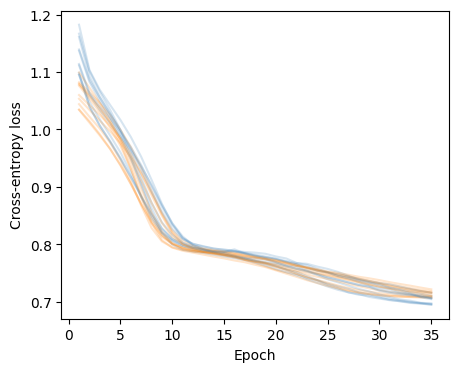

------------------------------ 
Training set:
Average log-likelihood = -5043.4 (36.3)
Average accuracy       = 71.1% (0.9%)
Average F1 score       = 62.8% (2.7%)
------------------------------ 
Validation set:
Average log-likelihood = -713.0 (4.7)
Average accuracy       = 70.4% (0.3%)
Average F1 score       = 62.0% (2.1%)
------------------------------ 
Test set:
Average log-likelihood = -1545.5 (9.3)
Average accuracy       = 69.1% (0.6%)
Average F1 score       = 60.3% (2.5%)
------------------------------ 
Training set:
Strong regularity = 0.000 (0.001)
Weak regularity   = 0.998 (0.003)
------------------------------ 
Validation set:
Strong regularity = 0.000 (0.001)
Weak regularity   = 0.998 (0.003)
------------------------------ 
Test set:
Strong regularity = 0.001 (0.001)
Weak regularity   = 0.998 (0.003)
------------------------------


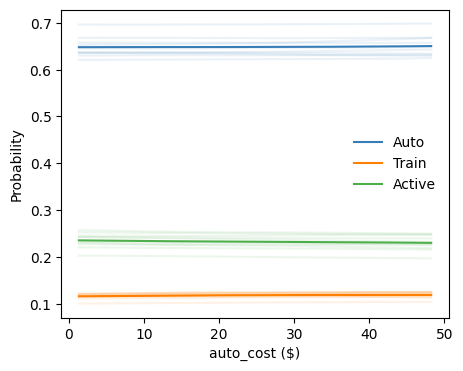

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -4798.5 | acc = 72.9% | F1 = 66.8%
Validation set: LL = -688.2  | acc = 71.5% | F1 = 65.5%
Test set:       LL = -1480.9 | acc = 70.7% | F1 = 64.3%
Model 2 
Training set:   LL = -4805.0 | acc = 72.7% | F1 = 66.6%
Validation set: LL = -690.7  | acc = 71.3% | F1 = 65.2%
Test set:       LL = -1483.9 | acc = 70.5% | F1 = 64.2%
Model 3 
Training set:   LL = -4815.9 | acc = 72.6% | F1 = 66.5%
Validation set: LL = -688.7  | acc = 71.5% | F1 = 65.4%
Test set:       LL = -1487.2 | acc = 70.3% | F1 = 63.9%
Model 4 
Training set:   LL = -4824.9 | acc = 72.7% | F1 = 66.6%
Validation set: LL = -689.7  | acc = 71.7% | F1 = 65.5%
Test set:       LL = -1489.6 | acc = 70.8% | F1 = 64.4%
Model 5 
Training set:   LL = -4823.9 | acc = 72.3% | F1 = 65.9%
Validation set: LL = -690.2  | acc = 71.2% | F1 = 65.0%
Test set:       LL = -1488.0 | acc = 70.5% | F1 = 63.8%
Model 6 
Training set:   LL = -4807.0 | acc = 72.6% | F1 = 66.5%
Valida

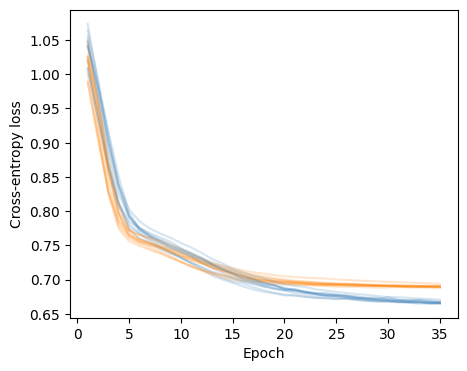

------------------------------ 
Training set:
Average log-likelihood = -4814.8 (12.1)
Average accuracy       = 72.6% (0.2%)
Average F1 score       = 66.4% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -690.1 (1.5)
Average accuracy       = 71.4% (0.2%)
Average F1 score       = 65.3% (0.2%)
------------------------------ 
Test set:
Average log-likelihood = -1484.9 (2.9)
Average accuracy       = 70.5% (0.2%)
Average F1 score       = 64.1% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.025 (0.012)
Weak regularity   = 0.973 (0.011)
------------------------------ 
Validation set:
Strong regularity = 0.023 (0.012)
Weak regularity   = 0.972 (0.012)
------------------------------ 
Test set:
Strong regularity = 0.025 (0.012)
Weak regularity   = 0.969 (0.015)
------------------------------


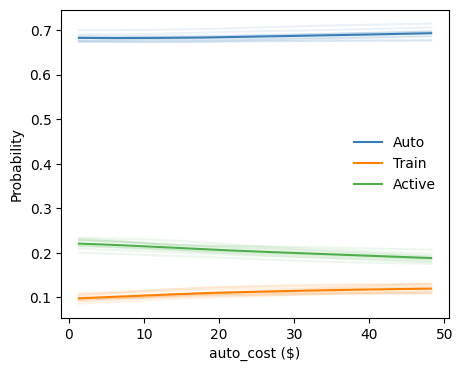

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -4757.6 | acc = 72.9% | F1 = 66.6%
Validation set: LL = -683.0  | acc = 71.7% | F1 = 65.4%
Test set:       LL = -1464.1 | acc = 70.8% | F1 = 64.4%
Model 2 
Training set:   LL = -4758.2 | acc = 72.9% | F1 = 66.7%
Validation set: LL = -681.4  | acc = 71.8% | F1 = 65.8%
Test set:       LL = -1468.6 | acc = 70.7% | F1 = 64.3%
Model 3 
Training set:   LL = -4778.0 | acc = 72.8% | F1 = 66.4%
Validation set: LL = -681.4  | acc = 72.1% | F1 = 65.9%
Test set:       LL = -1470.0 | acc = 70.8% | F1 = 64.1%
Model 4 
Training set:   LL = -4758.3 | acc = 73.0% | F1 = 66.9%
Validation set: LL = -682.8  | acc = 72.3% | F1 = 66.3%
Test set:       LL = -1463.4 | acc = 71.0% | F1 = 64.6%
Model 5 
Training set:   LL = -4737.4 | acc = 72.9% | F1 = 66.6%
Validation set: LL = -678.3  | acc = 72.1% | F1 = 66.0%
Test set:       LL = -1463.9 | acc = 71.2% | F1 = 64.7%
Model 6 
Training set:   LL = -4749.8 | acc = 73.0% | F1 = 66.8%
Validat

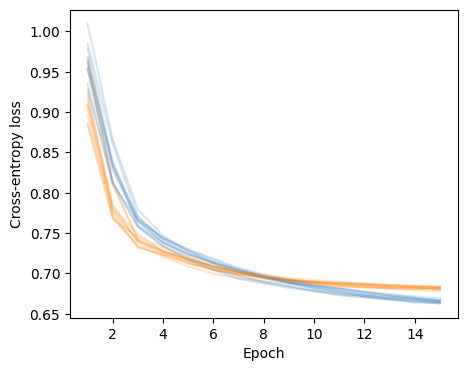

------------------------------ 
Training set:
Average log-likelihood = -4761.2 (11.0)
Average accuracy       = 72.8% (0.2%)
Average F1 score       = 66.4% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -681.5 (1.6)
Average accuracy       = 72.0% (0.2%)
Average F1 score       = 65.6% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1466.4 (3.4)
Average accuracy       = 70.7% (0.2%)
Average F1 score       = 64.0% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.334 (0.025)
Weak regularity   = 0.713 (0.035)
------------------------------ 
Validation set:
Strong regularity = 0.344 (0.033)
Weak regularity   = 0.718 (0.040)
------------------------------ 
Test set:
Strong regularity = 0.330 (0.024)
Weak regularity   = 0.711 (0.034)
------------------------------


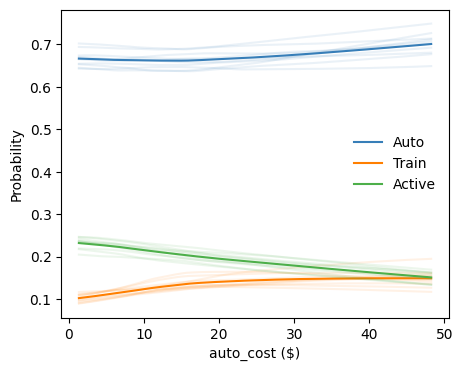

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4596.9 | acc = 73.5% | F1 = 68.1%
Validation set: LL = -666.2  | acc = 72.9% | F1 = 67.8%
Test set:       LL = -1424.6 | acc = 71.2% | F1 = 65.7%
Model 2 
Training set:   LL = -4570.0 | acc = 73.5% | F1 = 68.2%
Validation set: LL = -662.1  | acc = 72.8% | F1 = 67.7%
Test set:       LL = -1425.5 | acc = 71.3% | F1 = 65.8%
Model 3 
Training set:   LL = -4600.0 | acc = 73.2% | F1 = 67.7%
Validation set: LL = -664.0  | acc = 73.4% | F1 = 68.2%
Test set:       LL = -1432.4 | acc = 71.6% | F1 = 65.9%
Model 4 
Training set:   LL = -4597.8 | acc = 73.5% | F1 = 68.0%
Validation set: LL = -666.6  | acc = 73.4% | F1 = 68.2%
Test set:       LL = -1428.9 | acc = 71.5% | F1 = 65.8%
Model 5 
Training set:   LL = -4569.3 | acc = 73.6% | F1 = 68.2%
Validation set: LL = -660.0  | acc = 73.0% | F1 = 67.9%
Test set:       LL = -1431.7 | acc = 71.6% | F1 = 66.0%
Model 6 
Training set:   LL = -4591.0 | acc = 73.7% | F1 = 68.0%
Valid

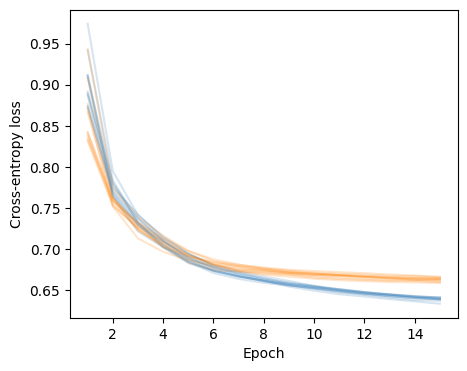

------------------------------ 
Training set:
Average log-likelihood = -4590.8 (15.2)
Average accuracy       = 73.5% (0.1%)
Average F1 score       = 68.0% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -663.3 (2.3)
Average accuracy       = 73.1% (0.2%)
Average F1 score       = 67.9% (0.2%)
------------------------------ 
Test set:
Average log-likelihood = -1428.4 (4.3)
Average accuracy       = 71.6% (0.2%)
Average F1 score       = 65.8% (0.1%)
------------------------------ 
Training set:
Strong regularity = 0.385 (0.034)
Weak regularity   = 0.525 (0.041)
------------------------------ 
Validation set:
Strong regularity = 0.388 (0.040)
Weak regularity   = 0.535 (0.042)
------------------------------ 
Test set:
Strong regularity = 0.379 (0.039)
Weak regularity   = 0.519 (0.046)
------------------------------


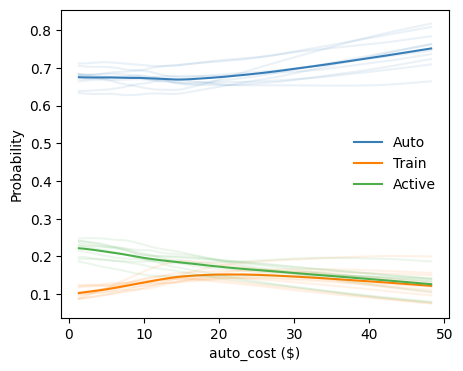

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4452.4 | acc = 74.0% | F1 = 68.7%
Validation set: LL = -651.3  | acc = 73.3% | F1 = 68.3%
Test set:       LL = -1391.3 | acc = 71.4% | F1 = 65.9%
Model 2 
Training set:   LL = -4429.8 | acc = 73.7% | F1 = 68.5%
Validation set: LL = -644.6  | acc = 73.6% | F1 = 68.8%
Test set:       LL = -1393.1 | acc = 72.0% | F1 = 66.5%
Model 3 
Training set:   LL = -4451.8 | acc = 73.8% | F1 = 68.6%
Validation set: LL = -646.6  | acc = 73.4% | F1 = 68.5%
Test set:       LL = -1394.4 | acc = 72.0% | F1 = 66.5%
Model 4 
Training set:   LL = -4440.4 | acc = 74.0% | F1 = 68.9%
Validation set: LL = -652.2  | acc = 74.1% | F1 = 69.4%
Test set:       LL = -1394.6 | acc = 71.5% | F1 = 66.0%
Model 5 
Training set:   LL = -4465.6 | acc = 73.7% | F1 = 68.1%
Validation set: LL = -645.1  | acc = 73.7% | F1 = 68.3%
Test set:       LL = -1402.3 | acc = 72.0% | F1 = 66.2%
Model 6 
Training set:   LL = -4466.1 | acc = 73.8% | F1 = 68.3%
Vali

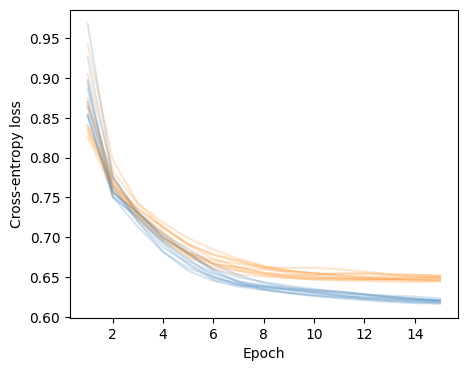

------------------------------ 
Training set:
Average log-likelihood = -4458.0 (14.9)
Average accuracy       = 73.8% (0.1%)
Average F1 score       = 68.4% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -648.3 (2.5)
Average accuracy       = 73.5% (0.2%)
Average F1 score       = 68.3% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1397.4 (4.1)
Average accuracy       = 71.7% (0.3%)
Average F1 score       = 66.0% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.596 (0.029)
Weak regularity   = 0.670 (0.028)
------------------------------ 
Validation set:
Strong regularity = 0.597 (0.032)
Weak regularity   = 0.680 (0.030)
------------------------------ 
Test set:
Strong regularity = 0.595 (0.024)
Weak regularity   = 0.669 (0.022)
------------------------------


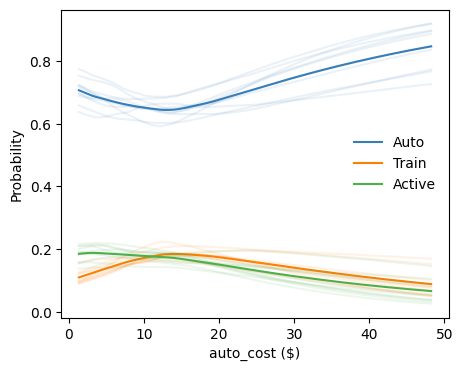

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4325.1 | acc = 74.4% | F1 = 69.8%
Validation set: LL = -637.7  | acc = 74.1% | F1 = 69.5%
Test set:       LL = -1360.8 | acc = 72.4% | F1 = 67.5%
Model 2 
Training set:   LL = -4320.5 | acc = 74.4% | F1 = 69.8%
Validation set: LL = -631.5  | acc = 74.4% | F1 = 70.0%
Test set:       LL = -1362.1 | acc = 73.0% | F1 = 68.5%
Model 3 
Training set:   LL = -4330.0 | acc = 74.3% | F1 = 69.6%
Validation set: LL = -638.1  | acc = 73.9% | F1 = 69.0%
Test set:       LL = -1364.1 | acc = 72.3% | F1 = 67.3%
Model 4 
Training set:   LL = -4310.1 | acc = 74.5% | F1 = 70.1%
Validation set: LL = -638.3  | acc = 74.0% | F1 = 70.0%
Test set:       LL = -1359.9 | acc = 73.0% | F1 = 68.3%
Model 5 
Training set:   LL = -4318.0 | acc = 74.5% | F1 = 70.0%
Validation set: LL = -628.7  | acc = 74.1% | F1 = 69.7%
Test set:       LL = -1363.5 | acc = 72.7% | F1 = 67.9%
Model 6 
Training set:   LL = -4344.4 | acc = 74.4% | F1 = 69.5%
Val

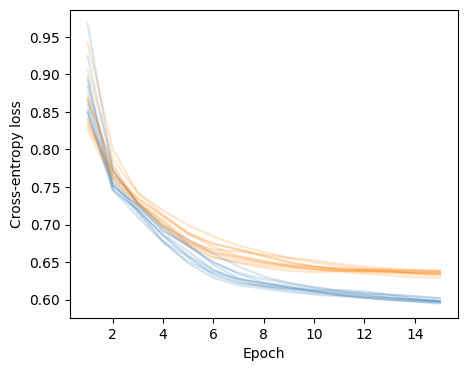

------------------------------ 
Training set:
Average log-likelihood = -4329.3 (10.7)
Average accuracy       = 74.4% (0.1%)
Average F1 score       = 69.7% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -634.9 (2.9)
Average accuracy       = 74.1% (0.3%)
Average F1 score       = 69.5% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1363.4 (4.0)
Average accuracy       = 72.4% (0.4%)
Average F1 score       = 67.4% (0.7%)
------------------------------ 
Training set:
Strong regularity = 0.700 (0.042)
Weak regularity   = 0.753 (0.046)
------------------------------ 
Validation set:
Strong regularity = 0.699 (0.040)
Weak regularity   = 0.762 (0.045)
------------------------------ 
Test set:
Strong regularity = 0.701 (0.046)
Weak regularity   = 0.749 (0.050)
------------------------------


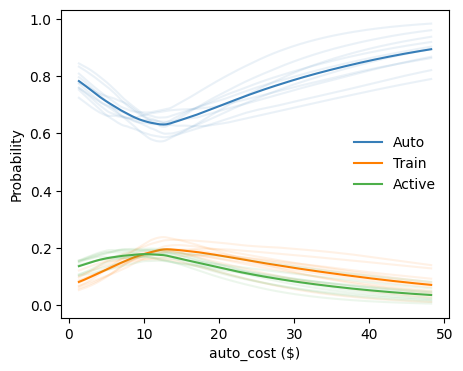

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4276.6 | acc = 75.2% | F1 = 71.6%
Validation set: LL = -636.3  | acc = 74.5% | F1 = 70.7%
Test set:       LL = -1348.8 | acc = 73.0% | F1 = 69.2%
Model 2 
Training set:   LL = -4274.5 | acc = 74.9% | F1 = 71.4%
Validation set: LL = -630.4  | acc = 74.6% | F1 = 71.0%
Test set:       LL = -1351.2 | acc = 73.3% | F1 = 69.5%
Model 3 
Training set:   LL = -4287.6 | acc = 74.8% | F1 = 70.9%
Validation set: LL = -637.7  | acc = 73.6% | F1 = 69.2%
Test set:       LL = -1355.2 | acc = 72.4% | F1 = 67.8%
Model 4 
Training set:   LL = -4257.7 | acc = 75.4% | F1 = 72.1%
Validation set: LL = -634.0  | acc = 74.0% | F1 = 70.5%
Test set:       LL = -1346.9 | acc = 73.5% | F1 = 69.9%
Model 5 
Training set:   LL = -4274.0 | acc = 74.9% | F1 = 71.5%
Validation set: LL = -629.0  | acc = 74.0% | F1 = 70.4%
Test set:       LL = -1358.2 | acc = 73.2% | F1 = 69.7%
Model 6 
Training set:   LL = -4286.5 | acc = 75.1% | F1 = 71.4%
Va

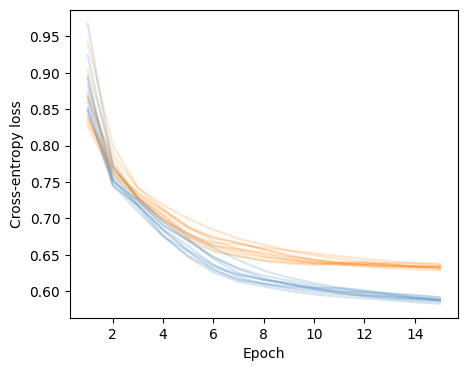

------------------------------ 
Training set:
Average log-likelihood = -4282.9 (12.2)
Average accuracy       = 75.0% (0.2%)
Average F1 score       = 71.3% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -633.3 (2.4)
Average accuracy       = 74.1% (0.4%)
Average F1 score       = 70.2% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1353.9 (5.0)
Average accuracy       = 72.9% (0.4%)
Average F1 score       = 68.8% (0.7%)
------------------------------ 
Training set:
Strong regularity = 0.856 (0.063)
Weak regularity   = 0.898 (0.062)
------------------------------ 
Validation set:
Strong regularity = 0.846 (0.058)
Weak regularity   = 0.900 (0.057)
------------------------------ 
Test set:
Strong regularity = 0.857 (0.069)
Weak regularity   = 0.893 (0.067)
------------------------------


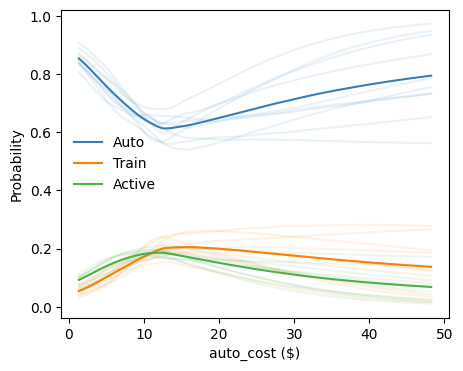

------------------------------ 
Model comparison:


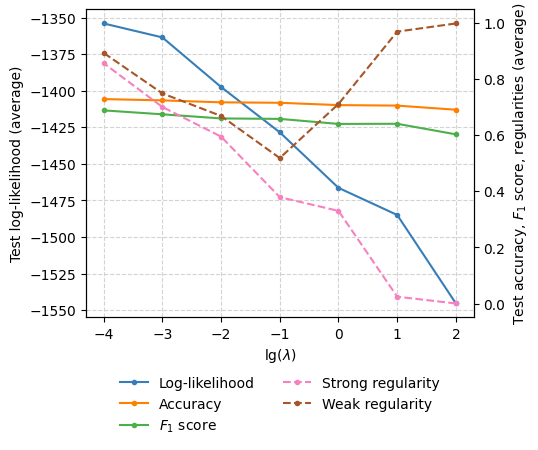

In [ ]:
# With norm
result(DNN, 15, 'PGR', [10**i for i in range(2, -5, -1)], 'norm')

### UGR

In [ ]:
# With sum
# result(DNN, 15, 'UGR', [10**i for i in range(2, -5, -1)])

Penalty = 100
------------------------------
Model 1 
Training set:   LL = -5668.3 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -797.1  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1663.6 | acc = 67.8% | F1 = 54.8%
Model 2 
Training set:   LL = -5670.9 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -798.5  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1664.0 | acc = 67.8% | F1 = 54.8%
Model 3 
Training set:   LL = -5668.7 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -797.6  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1663.8 | acc = 67.8% | F1 = 54.8%
Model 4 
Training set:   LL = -5668.6 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -798.1  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1663.2 | acc = 67.8% | F1 = 54.8%
Model 5 
Training set:   LL = -5671.1 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -797.6  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1664.5 | acc = 67.8% | F1 = 54.8%
Model 6 
Training set:   LL = -5672.5 | acc = 69.3% | F1 = 56.7%
Valid

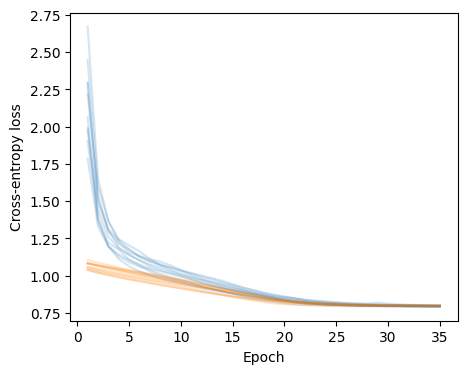

------------------------------ 
Training set:
Average log-likelihood = -5671.6 (2.9)
Average accuracy       = 69.3% (0.0%)
Average F1 score       = 56.7% (0.0%)
------------------------------ 
Validation set:
Average log-likelihood = -798.4 (0.9)
Average accuracy       = 69.7% (0.0%)
Average F1 score       = 57.3% (0.0%)
------------------------------ 
Test set:
Average log-likelihood = -1664.2 (0.6)
Average accuracy       = 67.8% (0.0%)
Average F1 score       = 54.8% (0.0%)
------------------------------ 
Training set:
Strong regularity = 0.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


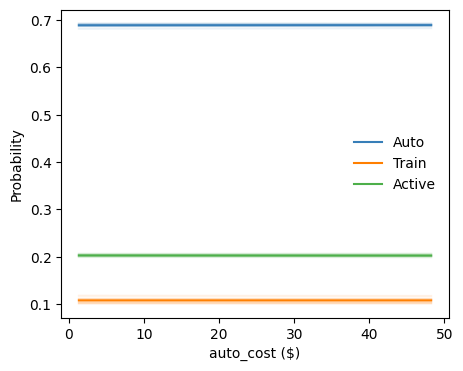

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -5013.0 | acc = 72.0% | F1 = 65.2%
Validation set: LL = -711.4  | acc = 70.4% | F1 = 63.6%
Test set:       LL = -1526.5 | acc = 69.8% | F1 = 62.5%
Model 2 
Training set:   LL = -4997.7 | acc = 72.0% | F1 = 65.8%
Validation set: LL = -708.5  | acc = 70.9% | F1 = 64.7%
Test set:       LL = -1528.5 | acc = 70.0% | F1 = 63.3%
Model 3 
Training set:   LL = -4985.6 | acc = 72.0% | F1 = 65.2%
Validation set: LL = -703.8  | acc = 70.9% | F1 = 64.1%
Test set:       LL = -1534.8 | acc = 69.8% | F1 = 62.6%
Model 4 
Training set:   LL = -4966.9 | acc = 72.2% | F1 = 65.6%
Validation set: LL = -702.3  | acc = 70.7% | F1 = 64.1%
Test set:       LL = -1528.0 | acc = 70.0% | F1 = 63.1%
Model 5 
Training set:   LL = -5041.3 | acc = 71.1% | F1 = 62.4%
Validation set: LL = -712.8  | acc = 70.6% | F1 = 61.8%
Test set:       LL = -1542.0 | acc = 68.9% | F1 = 59.6%
Model 6 
Training set:   LL = -5039.8 | acc = 71.7% | F1 = 64.2%
Valida

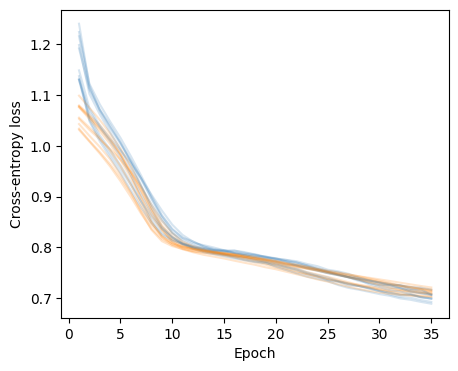

------------------------------ 
Training set:
Average log-likelihood = -5027.5 (41.3)
Average accuracy       = 71.5% (0.9%)
Average F1 score       = 63.7% (2.7%)
------------------------------ 
Validation set:
Average log-likelihood = -711.6 (5.6)
Average accuracy       = 70.6% (0.3%)
Average F1 score       = 62.8% (2.1%)
------------------------------ 
Test set:
Average log-likelihood = -1538.6 (10.7)
Average accuracy       = 69.5% (0.7%)
Average F1 score       = 61.2% (2.5%)
------------------------------ 
Training set:
Strong regularity = 0.001 (0.002)
Weak regularity   = 0.813 (0.248)
------------------------------ 
Validation set:
Strong regularity = 0.001 (0.002)
Weak regularity   = 0.819 (0.242)
------------------------------ 
Test set:
Strong regularity = 0.001 (0.002)
Weak regularity   = 0.810 (0.250)
------------------------------


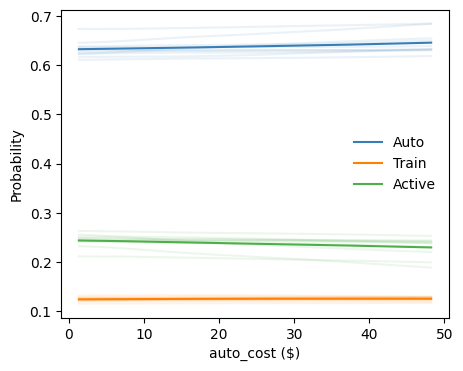

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -4902.9 | acc = 72.7% | F1 = 66.1%
Validation set: LL = -698.3  | acc = 71.4% | F1 = 64.8%
Test set:       LL = -1498.4 | acc = 70.7% | F1 = 63.8%
Model 2 
Training set:   LL = -4886.8 | acc = 72.7% | F1 = 66.5%
Validation set: LL = -693.6  | acc = 71.4% | F1 = 65.4%
Test set:       LL = -1493.2 | acc = 70.5% | F1 = 64.2%
Model 3 
Training set:   LL = -4959.1 | acc = 71.5% | F1 = 63.5%
Validation set: LL = -700.3  | acc = 71.2% | F1 = 63.2%
Test set:       LL = -1515.9 | acc = 69.5% | F1 = 61.1%
Model 4 
Training set:   LL = -4924.7 | acc = 72.1% | F1 = 65.1%
Validation set: LL = -699.8  | acc = 71.1% | F1 = 64.3%
Test set:       LL = -1507.2 | acc = 70.2% | F1 = 63.0%
Model 5 
Training set:   LL = -4943.8 | acc = 72.0% | F1 = 64.7%
Validation set: LL = -702.4  | acc = 71.3% | F1 = 64.0%
Test set:       LL = -1507.6 | acc = 70.0% | F1 = 62.1%
Model 6 
Training set:   LL = -4981.2 | acc = 71.3% | F1 = 63.1%
Validat

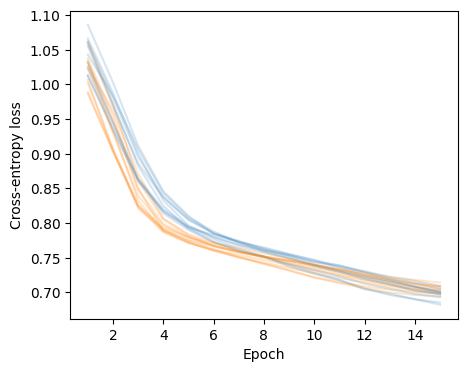

------------------------------ 
Training set:
Average log-likelihood = -4951.7 (36.5)
Average accuracy       = 71.8% (0.5%)
Average F1 score       = 64.3% (1.3%)
------------------------------ 
Validation set:
Average log-likelihood = -703.6 (5.7)
Average accuracy       = 71.1% (0.2%)
Average F1 score       = 63.4% (1.1%)
------------------------------ 
Test set:
Average log-likelihood = -1510.7 (9.2)
Average accuracy       = 69.8% (0.5%)
Average F1 score       = 61.8% (1.4%)
------------------------------ 
Training set:
Strong regularity = 0.009 (0.012)
Weak regularity   = 0.254 (0.127)
------------------------------ 
Validation set:
Strong regularity = 0.008 (0.010)
Weak regularity   = 0.261 (0.129)
------------------------------ 
Test set:
Strong regularity = 0.010 (0.012)
Weak regularity   = 0.248 (0.121)
------------------------------


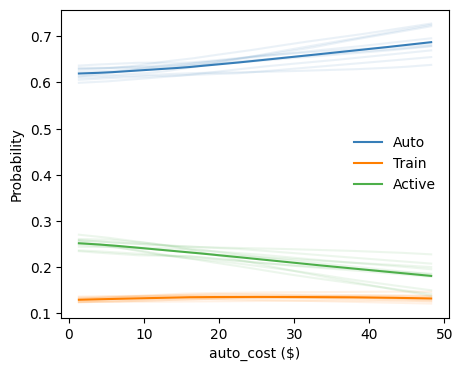

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4674.5 | acc = 73.4% | F1 = 68.0%
Validation set: LL = -673.2  | acc = 72.8% | F1 = 67.6%
Test set:       LL = -1447.1 | acc = 70.8% | F1 = 65.2%
Model 2 
Training set:   LL = -4659.0 | acc = 73.4% | F1 = 67.9%
Validation set: LL = -666.7  | acc = 73.2% | F1 = 68.0%
Test set:       LL = -1438.3 | acc = 71.3% | F1 = 65.6%
Model 3 
Training set:   LL = -4689.0 | acc = 73.2% | F1 = 67.4%
Validation set: LL = -668.5  | acc = 73.3% | F1 = 67.8%
Test set:       LL = -1444.0 | acc = 71.2% | F1 = 65.1%
Model 4 
Training set:   LL = -4686.8 | acc = 73.3% | F1 = 67.8%
Validation set: LL = -675.2  | acc = 73.3% | F1 = 68.1%
Test set:       LL = -1446.6 | acc = 71.5% | F1 = 65.6%
Model 5 
Training set:   LL = -4654.7 | acc = 73.2% | F1 = 67.8%
Validation set: LL = -667.1  | acc = 72.9% | F1 = 67.7%
Test set:       LL = -1436.6 | acc = 71.2% | F1 = 65.6%
Model 6 
Training set:   LL = -4680.0 | acc = 73.5% | F1 = 68.2%
Valid

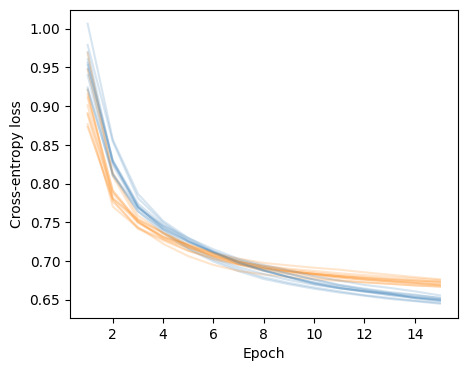

------------------------------ 
Training set:
Average log-likelihood = -4675.9 (16.9)
Average accuracy       = 73.3% (0.1%)
Average F1 score       = 67.8% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -671.1 (3.2)
Average accuracy       = 73.1% (0.2%)
Average F1 score       = 67.8% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1441.9 (4.7)
Average accuracy       = 71.2% (0.2%)
Average F1 score       = 65.5% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.140 (0.150)
Weak regularity   = 0.294 (0.151)
------------------------------ 
Validation set:
Strong regularity = 0.142 (0.149)
Weak regularity   = 0.311 (0.151)
------------------------------ 
Test set:
Strong regularity = 0.137 (0.143)
Weak regularity   = 0.285 (0.146)
------------------------------


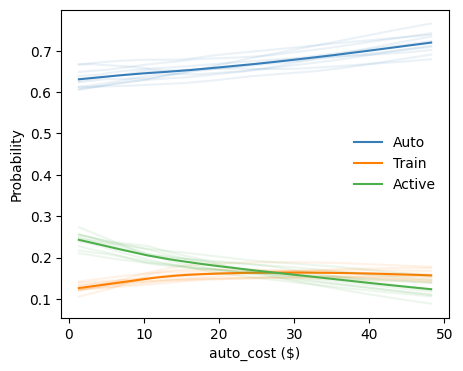

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4519.7 | acc = 73.8% | F1 = 68.5%
Validation set: LL = -658.0  | acc = 73.6% | F1 = 68.5%
Test set:       LL = -1401.8 | acc = 71.7% | F1 = 66.1%
Model 2 
Training set:   LL = -4513.6 | acc = 73.6% | F1 = 68.3%
Validation set: LL = -652.8  | acc = 73.5% | F1 = 68.3%
Test set:       LL = -1403.7 | acc = 71.5% | F1 = 65.8%
Model 3 
Training set:   LL = -4502.2 | acc = 73.5% | F1 = 68.2%
Validation set: LL = -648.5  | acc = 73.8% | F1 = 68.6%
Test set:       LL = -1396.2 | acc = 72.1% | F1 = 66.3%
Model 4 
Training set:   LL = -4535.5 | acc = 73.7% | F1 = 68.3%
Validation set: LL = -659.3  | acc = 73.6% | F1 = 68.4%
Test set:       LL = -1407.7 | acc = 71.9% | F1 = 66.2%
Model 5 
Training set:   LL = -4503.3 | acc = 73.5% | F1 = 68.4%
Validation set: LL = -649.9  | acc = 73.0% | F1 = 68.0%
Test set:       LL = -1400.5 | acc = 71.2% | F1 = 65.9%
Model 6 
Training set:   LL = -4523.9 | acc = 73.8% | F1 = 68.5%
Vali

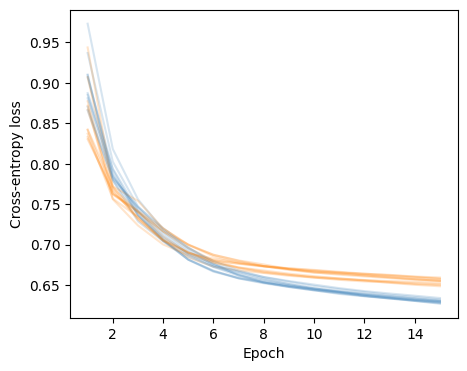

------------------------------ 
Training set:
Average log-likelihood = -4516.9 (16.4)
Average accuracy       = 73.7% (0.1%)
Average F1 score       = 68.4% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -654.3 (3.4)
Average accuracy       = 73.5% (0.3%)
Average F1 score       = 68.4% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1401.9 (4.0)
Average accuracy       = 71.7% (0.3%)
Average F1 score       = 66.1% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.461 (0.093)
Weak regularity   = 0.568 (0.080)
------------------------------ 
Validation set:
Strong regularity = 0.463 (0.101)
Weak regularity   = 0.575 (0.080)
------------------------------ 
Test set:
Strong regularity = 0.451 (0.094)
Weak regularity   = 0.561 (0.080)
------------------------------


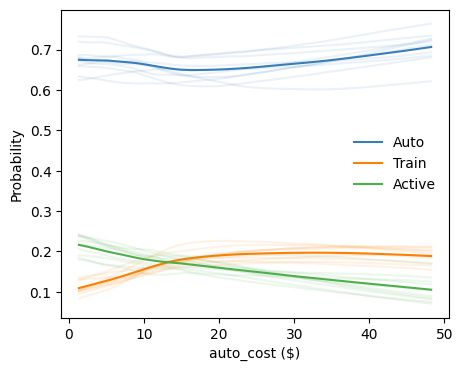

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4388.3 | acc = 74.3% | F1 = 69.8%
Validation set: LL = -644.5  | acc = 73.7% | F1 = 69.0%
Test set:       LL = -1370.8 | acc = 72.0% | F1 = 67.0%
Model 2 
Training set:   LL = -4392.1 | acc = 74.2% | F1 = 69.1%
Validation set: LL = -640.9  | acc = 74.0% | F1 = 69.0%
Test set:       LL = -1379.5 | acc = 72.0% | F1 = 66.6%
Model 3 
Training set:   LL = -4391.4 | acc = 74.1% | F1 = 69.4%
Validation set: LL = -639.4  | acc = 73.8% | F1 = 69.0%
Test set:       LL = -1367.8 | acc = 72.5% | F1 = 67.5%
Model 4 
Training set:   LL = -4390.5 | acc = 74.2% | F1 = 69.3%
Validation set: LL = -645.3  | acc = 73.9% | F1 = 69.3%
Test set:       LL = -1373.6 | acc = 72.1% | F1 = 66.9%
Model 5 
Training set:   LL = -4412.7 | acc = 74.0% | F1 = 68.8%
Validation set: LL = -642.4  | acc = 73.6% | F1 = 68.4%
Test set:       LL = -1382.8 | acc = 72.1% | F1 = 66.4%
Model 6 
Training set:   LL = -4413.9 | acc = 74.0% | F1 = 68.8%
Val

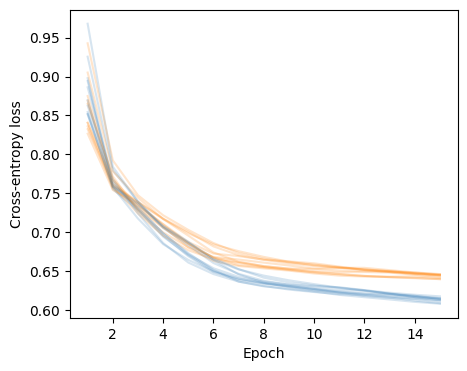

------------------------------ 
Training set:
Average log-likelihood = -4406.7 (17.1)
Average accuracy       = 74.1% (0.1%)
Average F1 score       = 69.2% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -643.1 (2.3)
Average accuracy       = 73.7% (0.2%)
Average F1 score       = 68.8% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1376.3 (4.9)
Average accuracy       = 72.1% (0.2%)
Average F1 score       = 66.9% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.607 (0.049)
Weak regularity   = 0.690 (0.048)
------------------------------ 
Validation set:
Strong regularity = 0.612 (0.051)
Weak regularity   = 0.702 (0.048)
------------------------------ 
Test set:
Strong regularity = 0.603 (0.052)
Weak regularity   = 0.684 (0.053)
------------------------------


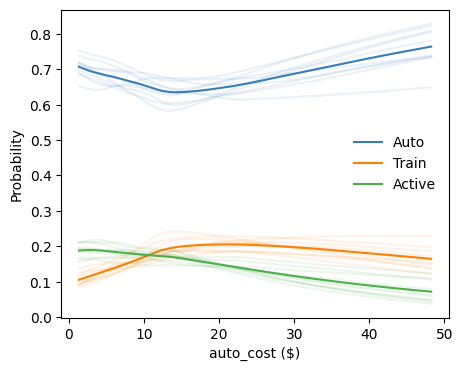

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4324.7 | acc = 74.6% | F1 = 70.4%
Validation set: LL = -637.1  | acc = 73.7% | F1 = 69.5%
Test set:       LL = -1359.0 | acc = 72.8% | F1 = 68.5%
Model 2 
Training set:   LL = -4318.8 | acc = 74.6% | F1 = 70.3%
Validation set: LL = -631.9  | acc = 74.6% | F1 = 70.4%
Test set:       LL = -1358.7 | acc = 72.9% | F1 = 68.4%
Model 3 
Training set:   LL = -4341.4 | acc = 74.4% | F1 = 69.8%
Validation set: LL = -640.7  | acc = 73.8% | F1 = 68.8%
Test set:       LL = -1363.6 | acc = 72.0% | F1 = 66.9%
Model 4 
Training set:   LL = -4313.8 | acc = 74.7% | F1 = 70.5%
Validation set: LL = -638.5  | acc = 74.4% | F1 = 70.5%
Test set:       LL = -1359.5 | acc = 73.0% | F1 = 68.5%
Model 5 
Training set:   LL = -4317.7 | acc = 74.7% | F1 = 70.7%
Validation set: LL = -631.5  | acc = 74.1% | F1 = 70.0%
Test set:       LL = -1361.4 | acc = 72.9% | F1 = 68.8%
Model 6 
Training set:   LL = -4342.7 | acc = 74.7% | F1 = 70.0%
Va

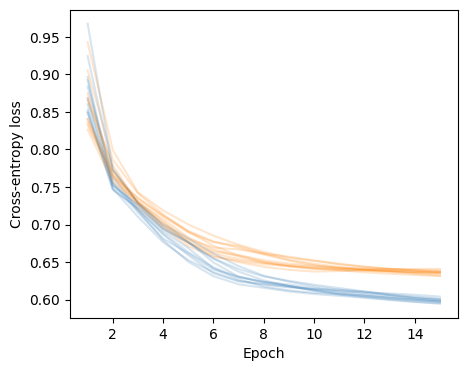

------------------------------ 
Training set:
Average log-likelihood = -4333.2 (14.3)
Average accuracy       = 74.5% (0.2%)
Average F1 score       = 70.0% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -635.9 (2.7)
Average accuracy       = 74.1% (0.3%)
Average F1 score       = 69.6% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -1362.0 (3.1)
Average accuracy       = 72.5% (0.4%)
Average F1 score       = 67.7% (0.9%)
------------------------------ 
Training set:
Strong regularity = 0.704 (0.044)
Weak regularity   = 0.761 (0.046)
------------------------------ 
Validation set:
Strong regularity = 0.701 (0.044)
Weak regularity   = 0.766 (0.046)
------------------------------ 
Test set:
Strong regularity = 0.706 (0.051)
Weak regularity   = 0.756 (0.051)
------------------------------


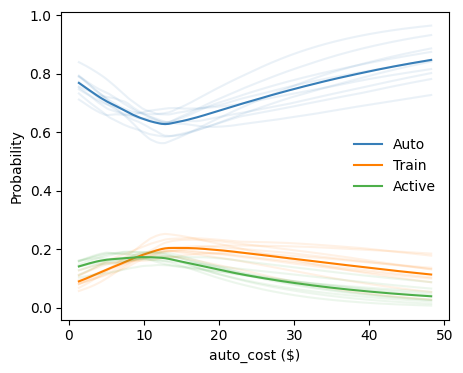

------------------------------ 
Model comparison:


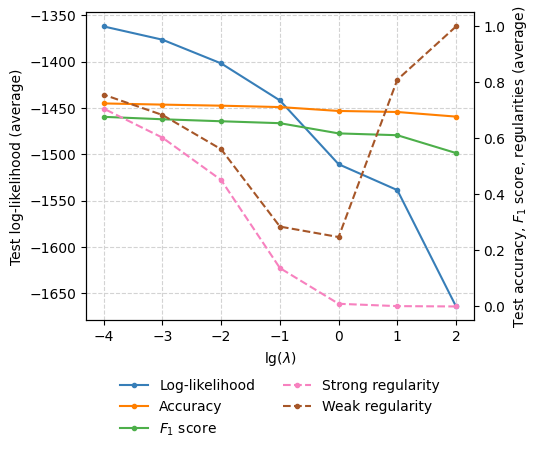

In [ ]:
# With norm
result(DNN, 15, 'UGR', [10**i for i in range(2, -5, -1)], 'norm')

### LGR

In [ ]:
# With sum
# result(DNN, 15, 'LGR', [10**i for i in range(2, -5, -1)])

Penalty = 100
------------------------------
Model 1 
Training set:   LL = -5563.6 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -783.8  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1640.2 | acc = 67.8% | F1 = 54.8%
Model 2 
Training set:   LL = -5528.7 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -779.1  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1633.8 | acc = 67.8% | F1 = 54.8%
Model 3 
Training set:   LL = -5625.8 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -791.7  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1653.7 | acc = 67.8% | F1 = 54.8%
Model 4 
Training set:   LL = -5452.9 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -769.3  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1619.4 | acc = 67.8% | F1 = 54.8%
Model 5 
Training set:   LL = -5645.0 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -794.1  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1657.8 | acc = 67.8% | F1 = 54.8%
Model 6 
Training set:   LL = -5556.7 | acc = 69.3% | F1 = 56.7%
Valid

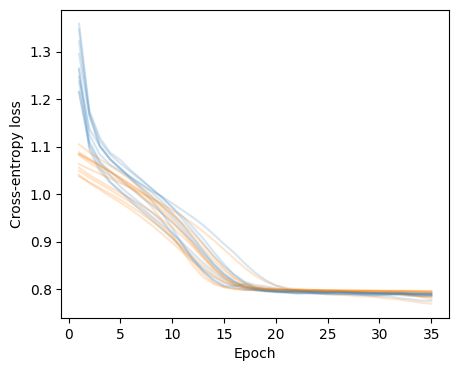

------------------------------ 
Training set:
Average log-likelihood = -5596.2 (64.9)
Average accuracy       = 69.3% (0.0%)
Average F1 score       = 56.7% (0.0%)
------------------------------ 
Validation set:
Average log-likelihood = -788.0 (8.4)
Average accuracy       = 69.7% (0.0%)
Average F1 score       = 57.3% (0.0%)
------------------------------ 
Test set:
Average log-likelihood = -1647.8 (13.4)
Average accuracy       = 67.8% (0.0%)
Average F1 score       = 54.8% (0.0%)
------------------------------ 
Training set:
Strong regularity = 0.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.000 (0.000)
Weak regularity   = 1.000 (0.001)
------------------------------


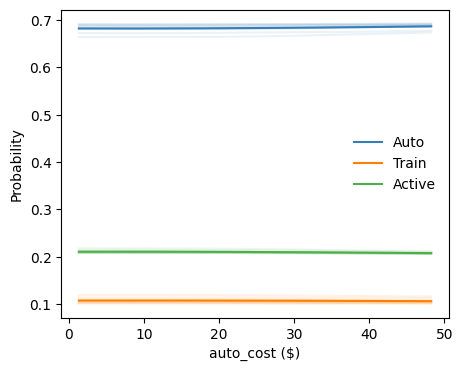

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -4952.3 | acc = 72.1% | F1 = 65.7%
Validation set: LL = -705.9  | acc = 70.7% | F1 = 64.2%
Test set:       LL = -1514.1 | acc = 70.1% | F1 = 63.3%
Model 2 
Training set:   LL = -4957.8 | acc = 72.1% | F1 = 65.7%
Validation set: LL = -705.8  | acc = 70.8% | F1 = 64.5%
Test set:       LL = -1513.5 | acc = 70.2% | F1 = 63.4%
Model 3 
Training set:   LL = -4994.3 | acc = 72.0% | F1 = 65.4%
Validation set: LL = -709.8  | acc = 70.8% | F1 = 64.1%
Test set:       LL = -1526.3 | acc = 69.8% | F1 = 62.8%
Model 4 
Training set:   LL = -4978.3 | acc = 72.1% | F1 = 65.5%
Validation set: LL = -706.9  | acc = 70.8% | F1 = 64.2%
Test set:       LL = -1522.2 | acc = 70.2% | F1 = 63.2%
Model 5 
Training set:   LL = -4954.4 | acc = 72.1% | F1 = 65.5%
Validation set: LL = -706.7  | acc = 70.8% | F1 = 64.2%
Test set:       LL = -1518.9 | acc = 70.0% | F1 = 63.0%
Model 6 
Training set:   LL = -4975.2 | acc = 72.1% | F1 = 65.5%
Valida

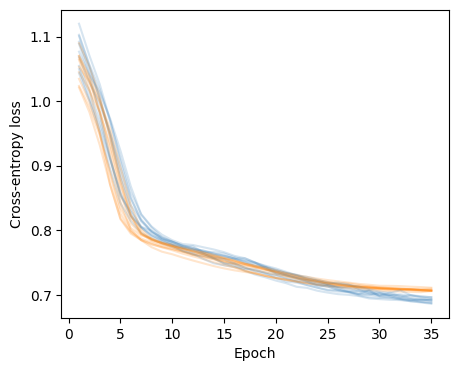

------------------------------ 
Training set:
Average log-likelihood = -4972.2 (16.5)
Average accuracy       = 72.1% (0.1%)
Average F1 score       = 65.5% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -707.4 (1.7)
Average accuracy       = 70.7% (0.1%)
Average F1 score       = 64.1% (0.2%)
------------------------------ 
Test set:
Average log-likelihood = -1520.3 (5.1)
Average accuracy       = 69.9% (0.2%)
Average F1 score       = 63.0% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.015 (0.008)
Weak regularity   = 0.983 (0.008)
------------------------------ 
Validation set:
Strong regularity = 0.015 (0.007)
Weak regularity   = 0.982 (0.007)
------------------------------ 
Test set:
Strong regularity = 0.017 (0.008)
Weak regularity   = 0.982 (0.008)
------------------------------


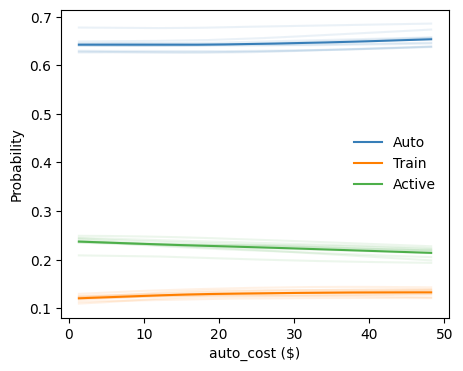

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -4897.4 | acc = 71.8% | F1 = 64.3%
Validation set: LL = -699.6  | acc = 71.2% | F1 = 63.5%
Test set:       LL = -1491.9 | acc = 69.8% | F1 = 61.8%
Model 2 
Training set:   LL = -4904.1 | acc = 71.6% | F1 = 63.9%
Validation set: LL = -697.4  | acc = 71.1% | F1 = 63.2%
Test set:       LL = -1493.6 | acc = 69.7% | F1 = 61.4%
Model 3 
Training set:   LL = -4928.4 | acc = 71.5% | F1 = 63.6%
Validation set: LL = -698.8  | acc = 71.3% | F1 = 63.2%
Test set:       LL = -1502.8 | acc = 69.4% | F1 = 61.0%
Model 4 
Training set:   LL = -4914.7 | acc = 72.0% | F1 = 64.7%
Validation set: LL = -699.3  | acc = 71.0% | F1 = 63.7%
Test set:       LL = -1493.5 | acc = 70.1% | F1 = 62.4%
Model 5 
Training set:   LL = -4889.5 | acc = 72.0% | F1 = 64.4%
Validation set: LL = -696.2  | acc = 71.1% | F1 = 63.2%
Test set:       LL = -1489.3 | acc = 70.1% | F1 = 61.8%
Model 6 
Training set:   LL = -4907.0 | acc = 71.8% | F1 = 64.2%
Validat

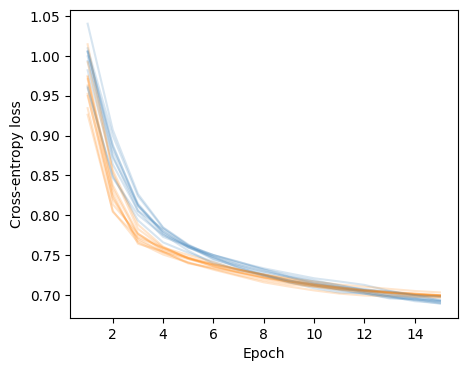

------------------------------ 
Training set:
Average log-likelihood = -4909.3 (13.8)
Average accuracy       = 71.7% (0.3%)
Average F1 score       = 63.8% (0.7%)
------------------------------ 
Validation set:
Average log-likelihood = -698.9 (1.7)
Average accuracy       = 71.0% (0.2%)
Average F1 score       = 62.9% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -1495.5 (4.0)
Average accuracy       = 69.6% (0.3%)
Average F1 score       = 61.2% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.252 (0.052)
Weak regularity   = 0.688 (0.074)
------------------------------ 
Validation set:
Strong regularity = 0.260 (0.048)
Weak regularity   = 0.696 (0.066)
------------------------------ 
Test set:
Strong regularity = 0.248 (0.053)
Weak regularity   = 0.687 (0.072)
------------------------------


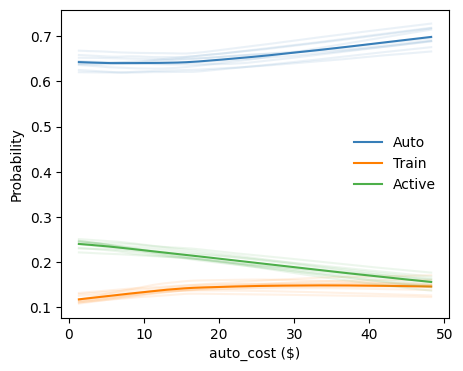

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4682.5 | acc = 73.0% | F1 = 66.9%
Validation set: LL = -676.8  | acc = 72.0% | F1 = 66.0%
Test set:       LL = -1442.5 | acc = 71.2% | F1 = 64.8%
Model 2 
Training set:   LL = -4697.7 | acc = 73.0% | F1 = 67.1%
Validation set: LL = -675.0  | acc = 72.1% | F1 = 66.4%
Test set:       LL = -1445.3 | acc = 71.1% | F1 = 65.0%
Model 3 
Training set:   LL = -4738.5 | acc = 72.9% | F1 = 66.7%
Validation set: LL = -675.5  | acc = 72.7% | F1 = 66.7%
Test set:       LL = -1458.0 | acc = 70.7% | F1 = 64.1%
Model 4 
Training set:   LL = -4718.2 | acc = 72.9% | F1 = 66.9%
Validation set: LL = -679.3  | acc = 72.4% | F1 = 66.5%
Test set:       LL = -1448.4 | acc = 71.0% | F1 = 64.5%
Model 5 
Training set:   LL = -4684.6 | acc = 73.1% | F1 = 66.9%
Validation set: LL = -672.1  | acc = 72.2% | F1 = 66.1%
Test set:       LL = -1448.3 | acc = 71.2% | F1 = 64.7%
Model 6 
Training set:   LL = -4682.9 | acc = 73.2% | F1 = 66.9%
Valid

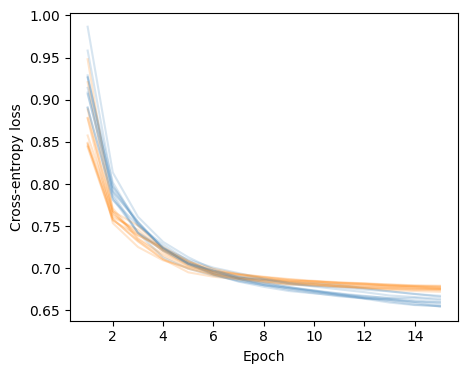

------------------------------ 
Training set:
Average log-likelihood = -4707.6 (19.2)
Average accuracy       = 73.0% (0.1%)
Average F1 score       = 66.7% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -676.1 (2.1)
Average accuracy       = 72.5% (0.3%)
Average F1 score       = 66.4% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1449.5 (4.4)
Average accuracy       = 70.9% (0.3%)
Average F1 score       = 64.3% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.341 (0.056)
Weak regularity   = 0.515 (0.059)
------------------------------ 
Validation set:
Strong regularity = 0.346 (0.057)
Weak regularity   = 0.523 (0.061)
------------------------------ 
Test set:
Strong regularity = 0.332 (0.056)
Weak regularity   = 0.511 (0.059)
------------------------------


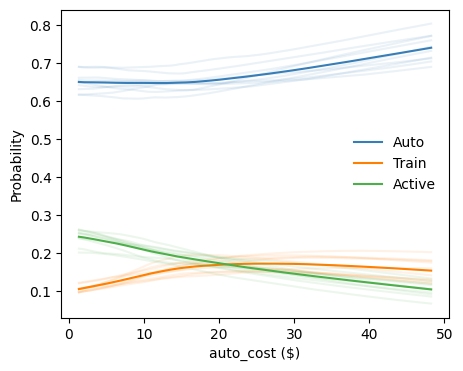

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4542.8 | acc = 73.7% | F1 = 67.9%
Validation set: LL = -663.7  | acc = 73.2% | F1 = 67.6%
Test set:       LL = -1416.3 | acc = 71.5% | F1 = 65.5%
Model 2 
Training set:   LL = -4534.3 | acc = 73.8% | F1 = 68.8%
Validation set: LL = -656.7  | acc = 73.0% | F1 = 68.3%
Test set:       LL = -1405.6 | acc = 71.2% | F1 = 65.9%
Model 3 
Training set:   LL = -4541.3 | acc = 73.5% | F1 = 68.2%
Validation set: LL = -656.2  | acc = 74.0% | F1 = 69.1%
Test set:       LL = -1413.2 | acc = 71.8% | F1 = 66.2%
Model 4 
Training set:   LL = -4536.5 | acc = 73.4% | F1 = 68.5%
Validation set: LL = -660.6  | acc = 73.7% | F1 = 69.3%
Test set:       LL = -1409.3 | acc = 71.9% | F1 = 66.7%
Model 5 
Training set:   LL = -4546.1 | acc = 73.6% | F1 = 68.1%
Validation set: LL = -655.6  | acc = 73.5% | F1 = 68.3%
Test set:       LL = -1415.6 | acc = 71.4% | F1 = 65.7%
Model 6 
Training set:   LL = -4551.9 | acc = 73.6% | F1 = 68.2%
Vali

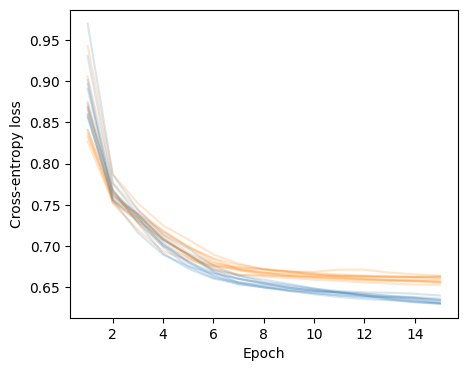

------------------------------ 
Training set:
Average log-likelihood = -4548.3 (16.8)
Average accuracy       = 73.6% (0.1%)
Average F1 score       = 68.0% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -659.2 (3.6)
Average accuracy       = 73.4% (0.4%)
Average F1 score       = 68.0% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -1415.0 (7.2)
Average accuracy       = 71.5% (0.3%)
Average F1 score       = 65.6% (0.7%)
------------------------------ 
Training set:
Strong regularity = 0.501 (0.046)
Weak regularity   = 0.574 (0.046)
------------------------------ 
Validation set:
Strong regularity = 0.502 (0.053)
Weak regularity   = 0.579 (0.056)
------------------------------ 
Test set:
Strong regularity = 0.497 (0.044)
Weak regularity   = 0.573 (0.045)
------------------------------


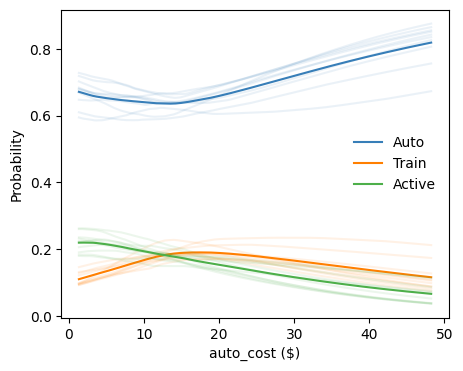

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4387.5 | acc = 74.0% | F1 = 69.3%
Validation set: LL = -643.2  | acc = 73.4% | F1 = 68.6%
Test set:       LL = -1370.3 | acc = 72.0% | F1 = 67.0%
Model 2 
Training set:   LL = -4407.6 | acc = 74.2% | F1 = 68.9%
Validation set: LL = -644.1  | acc = 73.9% | F1 = 68.6%
Test set:       LL = -1386.7 | acc = 72.0% | F1 = 66.5%
Model 3 
Training set:   LL = -4391.6 | acc = 73.9% | F1 = 69.1%
Validation set: LL = -642.4  | acc = 73.8% | F1 = 69.0%
Test set:       LL = -1375.7 | acc = 72.0% | F1 = 66.8%
Model 4 
Training set:   LL = -4387.6 | acc = 74.1% | F1 = 69.1%
Validation set: LL = -646.2  | acc = 73.9% | F1 = 69.2%
Test set:       LL = -1377.4 | acc = 72.2% | F1 = 66.7%
Model 5 
Training set:   LL = -4401.5 | acc = 73.9% | F1 = 68.6%
Validation set: LL = -636.9  | acc = 73.7% | F1 = 68.6%
Test set:       LL = -1379.8 | acc = 72.2% | F1 = 66.3%
Model 6 
Training set:   LL = -4402.7 | acc = 74.0% | F1 = 68.6%
Val

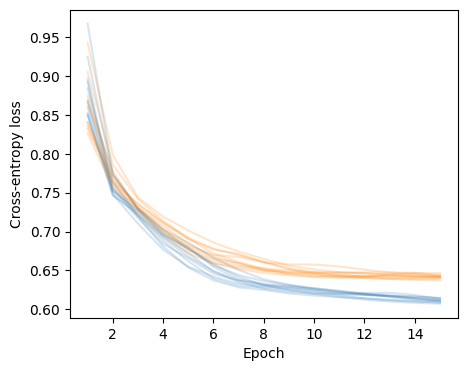

------------------------------ 
Training set:
Average log-likelihood = -4399.5 (9.3)
Average accuracy       = 74.0% (0.1%)
Average F1 score       = 68.8% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -641.8 (2.4)
Average accuracy       = 73.7% (0.3%)
Average F1 score       = 68.6% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1377.9 (4.5)
Average accuracy       = 71.9% (0.2%)
Average F1 score       = 66.4% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.687 (0.050)
Weak regularity   = 0.727 (0.054)
------------------------------ 
Validation set:
Strong regularity = 0.684 (0.047)
Weak regularity   = 0.729 (0.053)
------------------------------ 
Test set:
Strong regularity = 0.688 (0.048)
Weak regularity   = 0.723 (0.052)
------------------------------


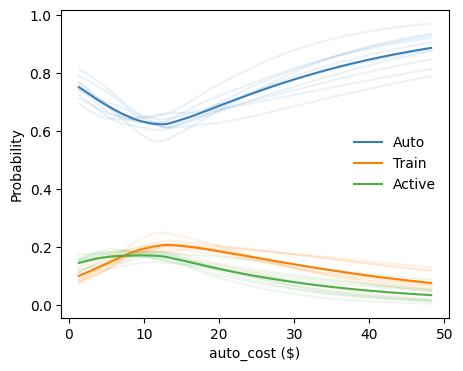

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4296.6 | acc = 74.9% | F1 = 71.0%
Validation set: LL = -635.9  | acc = 74.3% | F1 = 70.2%
Test set:       LL = -1348.8 | acc = 72.9% | F1 = 69.0%
Model 2 
Training set:   LL = -4293.4 | acc = 74.7% | F1 = 70.8%
Validation set: LL = -629.8  | acc = 74.5% | F1 = 70.7%
Test set:       LL = -1352.8 | acc = 73.0% | F1 = 69.0%
Model 3 
Training set:   LL = -4307.4 | acc = 74.7% | F1 = 70.4%
Validation set: LL = -638.1  | acc = 73.9% | F1 = 69.5%
Test set:       LL = -1354.8 | acc = 72.3% | F1 = 67.6%
Model 4 
Training set:   LL = -4282.5 | acc = 75.0% | F1 = 71.2%
Validation set: LL = -635.9  | acc = 74.2% | F1 = 70.4%
Test set:       LL = -1349.9 | acc = 73.2% | F1 = 69.3%
Model 5 
Training set:   LL = -4292.0 | acc = 74.8% | F1 = 71.1%
Validation set: LL = -627.5  | acc = 74.2% | F1 = 70.2%
Test set:       LL = -1355.1 | acc = 73.0% | F1 = 69.2%
Model 6 
Training set:   LL = -4318.1 | acc = 74.8% | F1 = 70.4%
Va

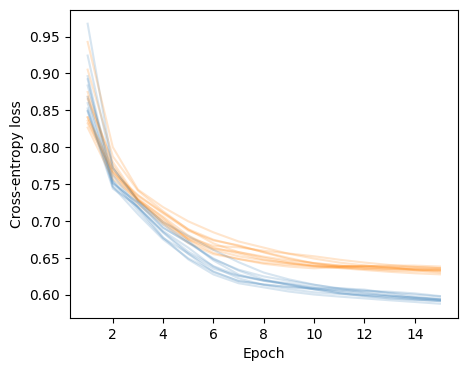

------------------------------ 
Training set:
Average log-likelihood = -4303.7 (12.0)
Average accuracy       = 74.8% (0.1%)
Average F1 score       = 70.6% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -633.3 (3.0)
Average accuracy       = 74.1% (0.3%)
Average F1 score       = 69.9% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1354.0 (4.5)
Average accuracy       = 72.7% (0.3%)
Average F1 score       = 68.3% (0.7%)
------------------------------ 
Training set:
Strong regularity = 0.813 (0.063)
Weak regularity   = 0.855 (0.065)
------------------------------ 
Validation set:
Strong regularity = 0.803 (0.061)
Weak regularity   = 0.858 (0.062)
------------------------------ 
Test set:
Strong regularity = 0.815 (0.068)
Weak regularity   = 0.851 (0.069)
------------------------------


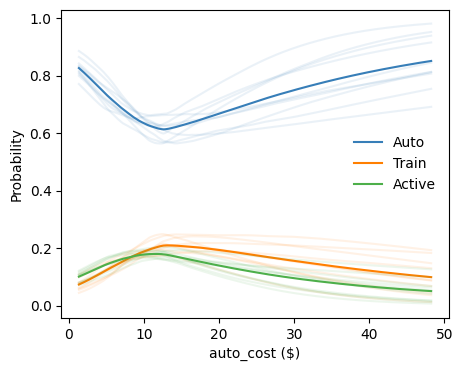

------------------------------ 
Model comparison:


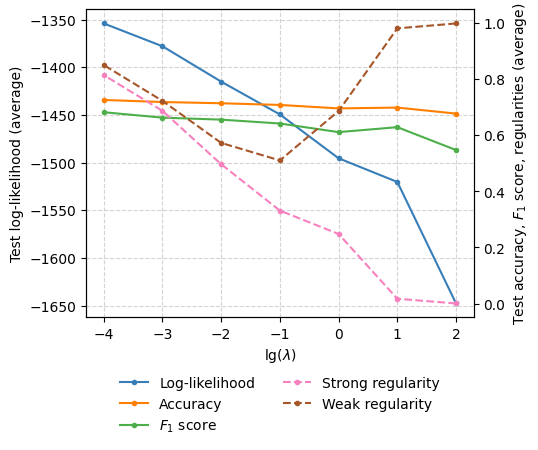

In [ ]:
# With norm
result(DNN, 15, 'LGR', [10**i for i in range(2, -5, -1)], 'norm')

## TasteNet
A flexible NN-based choice model proposed by [Han et al. (2022)](https://doi.org/10.1016/j.trb.2022.07.001). Here is a special case that learns all $\beta$'s from TasteNet.

In [ ]:
class TasteNet(nn.Module):
    'Class of TasteNet'
    def __init__(self):
        super(TasteNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(8, 100),
            nn.ReLU(),
            nn.Linear(100, 7)
        )

    def forward(self, x):
        'Function to specify utilities using TasteNet parameters'
        betas = self.seq(x[:, :8])
        V1 = betas[:, 0] * torch.ones(len(x)) + torch.sum(betas[:, 1:3] * x[:, 8:10], dim=1)
        V2 = betas[:, 3] * torch.ones(len(x)) + torch.sum(betas[:, 4:6] * x[:, 10:12], dim=1)
        V3 = betas[:, 6] * x[:, 12]
        return torch.stack((V1, V2, V3), dim=1)

### Without GR

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -4683.3 | acc = 73.2% | F1 = 67.4%
Validation set: LL = -685.0  | acc = 72.4% | F1 = 66.7%
Test set:       LL = -1439.3 | acc = 70.8% | F1 = 64.6%
Model 2 
Training set:   LL = -4679.2 | acc = 73.6% | F1 = 68.0%
Validation set: LL = -682.5  | acc = 73.1% | F1 = 67.3%
Test set:       LL = -1441.0 | acc = 71.4% | F1 = 65.5%
Model 3 
Training set:   LL = -4662.7 | acc = 73.2% | F1 = 67.6%
Validation set: LL = -681.1  | acc = 72.5% | F1 = 66.7%
Test set:       LL = -1433.2 | acc = 71.4% | F1 = 65.4%
Model 4 
Training set:   LL = -4683.9 | acc = 73.2% | F1 = 67.3%
Validation set: LL = -688.0  | acc = 72.4% | F1 = 66.2%
Test set:       LL = -1440.0 | acc = 71.0% | F1 = 64.8%
Model 5 
Training set:   LL = -4703.7 | acc = 73.1% | F1 = 67.2%
Validation set: LL = -679.7  | acc = 72.6% | F1 = 66.6%
Test set:       LL = -1438.2 | acc = 71.7% | F1 = 65.8%
Model 6 
Training set:   LL = -4689.6 | acc = 73.2% | F1 = 67.4%
Validat

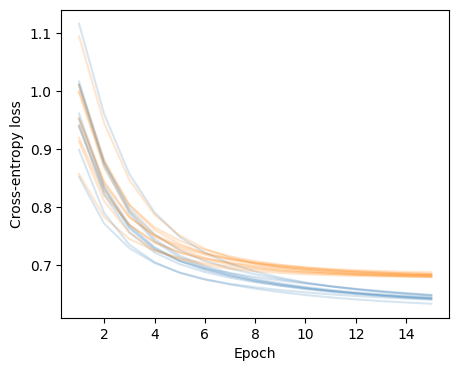

------------------------------ 
Training set:
Average log-likelihood = -4677.8 (19.9)
Average accuracy       = 73.2% (0.2%)
Average F1 score       = 67.5% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -683.0 (2.4)
Average accuracy       = 72.6% (0.4%)
Average F1 score       = 66.8% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1438.3 (5.8)
Average accuracy       = 71.3% (0.3%)
Average F1 score       = 65.4% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.997 (0.003)
Weak regularity   = 0.999 (0.002)
------------------------------ 
Validation set:
Strong regularity = 0.997 (0.005)
Weak regularity   = 0.998 (0.003)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 0.999 (0.002)
------------------------------


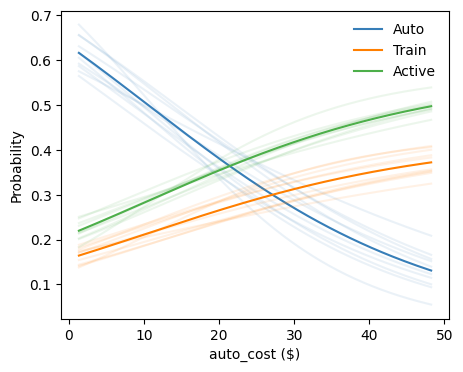

In [ ]:
result(TasteNet, 15, 'none')

### PGR

In [ ]:
# With sum
# result(TasteNet, 15, 'PGR', [10**i for i in range(1, -6, -1)])

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -13066.4 | acc = 10.0% | F1 = 1.8%
Validation set: LL = -1880.0 | acc = 8.9% | F1 = 1.5%
Test set:       LL = -3715.5 | acc = 10.5% | F1 = 2.0%
Model 2 
Training set:   LL = -13159.3 | acc = 10.0% | F1 = 1.8%
Validation set: LL = -1896.9 | acc = 8.9% | F1 = 1.5%
Test set:       LL = -3751.6 | acc = 10.5% | F1 = 2.0%
Model 3 
Training set:   LL = -8679.8 | acc = 22.2% | F1 = 21.2%
Validation set: LL = -1226.9 | acc = 22.0% | F1 = 20.2%
Test set:       LL = -2457.5 | acc = 24.1% | F1 = 22.6%
Model 4 
Training set:   LL = -7439.9 | acc = 46.3% | F1 = 46.8%
Validation set: LL = -1093.3 | acc = 45.4% | F1 = 46.0%
Test set:       LL = -2154.3 | acc = 45.9% | F1 = 45.9%
Model 5 
Training set:   LL = -14386.0 | acc = 10.0% | F1 = 1.8%
Validation set: LL = -2077.0 | acc = 8.9% | F1 = 1.5%
Test set:       LL = -4099.7 | acc = 10.5% | F1 = 2.0%
Model 6 
Training set:   LL = -14805.3 | acc = 10.0% | F1 = 1.8%
Validation set:

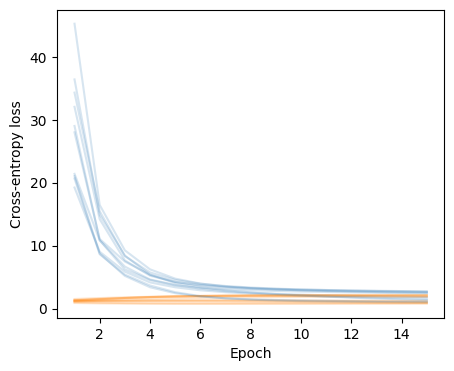

------------------------------ 
Training set:
Average log-likelihood = -10441.3 (3660.3)
Average accuracy       = 31.8% (25.2%)
Average F1 score       = 24.6% (24.7%)
------------------------------ 
Validation set:
Average log-likelihood = -1500.5 (537.4)
Average accuracy       = 31.1% (25.6%)
Average F1 score       = 24.3% (24.9%)
------------------------------ 
Test set:
Average log-likelihood = -3003.0 (1017.0)
Average accuracy       = 31.6% (24.0%)
Average F1 score       = 24.0% (23.6%)
------------------------------ 
Training set:
Strong regularity = 0.411 (0.034)
Weak regularity   = 0.588 (0.024)
------------------------------ 
Validation set:
Strong regularity = 0.411 (0.034)
Weak regularity   = 0.593 (0.029)
------------------------------ 
Test set:
Strong regularity = 0.413 (0.037)
Weak regularity   = 0.585 (0.030)
------------------------------


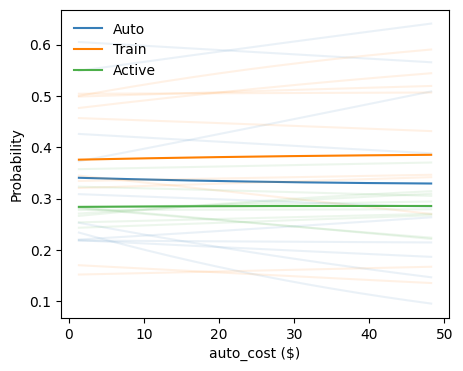

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -5554.6 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -795.7  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1642.1 | acc = 67.8% | F1 = 54.8%
Model 2 
Training set:   LL = -5413.6 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -754.7  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1634.2 | acc = 67.8% | F1 = 54.8%
Model 3 
Training set:   LL = -5810.7 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -812.5  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1696.6 | acc = 67.8% | F1 = 54.8%
Model 4 
Training set:   LL = -5442.0 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -770.1  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1631.1 | acc = 67.8% | F1 = 54.8%
Model 5 
Training set:   LL = -6531.2 | acc = 60.5% | F1 = 60.5%
Validation set: LL = -933.7  | acc = 59.1% | F1 = 59.6%
Test set:       LL = -1898.7 | acc = 58.9% | F1 = 58.7%
Model 6 
Training set:   LL = -5634.0 | acc = 69.3% | F1 = 56.7%
Validat

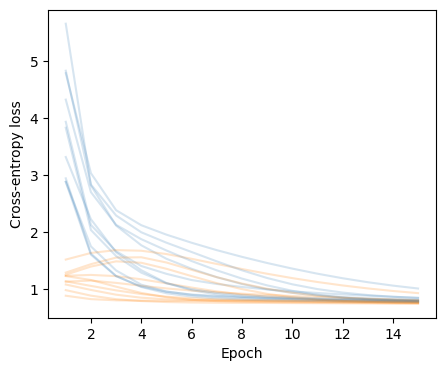

------------------------------ 
Training set:
Average log-likelihood = -5619.9 (328.5)
Average accuracy       = 68.4% (2.6%)
Average F1 score       = 57.1% (1.1%)
------------------------------ 
Validation set:
Average log-likelihood = -793.6 (50.8)
Average accuracy       = 68.6% (3.2%)
Average F1 score       = 57.5% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1670.8 (79.4)
Average accuracy       = 66.9% (2.7%)
Average F1 score       = 55.2% (1.2%)
------------------------------ 
Training set:
Strong regularity = 0.393 (0.035)
Weak regularity   = 0.569 (0.030)
------------------------------ 
Validation set:
Strong regularity = 0.388 (0.029)
Weak regularity   = 0.573 (0.026)
------------------------------ 
Test set:
Strong regularity = 0.392 (0.039)
Weak regularity   = 0.566 (0.034)
------------------------------


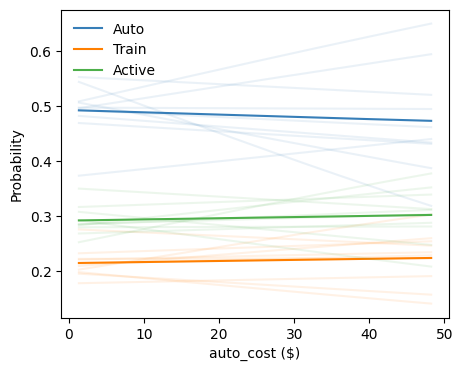

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -5182.0 | acc = 70.1% | F1 = 59.9%
Validation set: LL = -736.0  | acc = 70.1% | F1 = 59.9%
Test set:       LL = -1575.7 | acc = 68.3% | F1 = 57.5%
Model 2 
Training set:   LL = -5155.6 | acc = 69.9% | F1 = 58.5%
Validation set: LL = -725.5  | acc = 69.9% | F1 = 57.9%
Test set:       LL = -1570.8 | acc = 68.0% | F1 = 56.1%
Model 3 
Training set:   LL = -5146.3 | acc = 70.2% | F1 = 60.1%
Validation set: LL = -724.5  | acc = 70.2% | F1 = 60.2%
Test set:       LL = -1566.3 | acc = 68.2% | F1 = 57.3%
Model 4 
Training set:   LL = -5163.8 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -732.6  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1569.3 | acc = 67.8% | F1 = 54.8%
Model 5 
Training set:   LL = -5163.9 | acc = 70.4% | F1 = 60.9%
Validation set: LL = -726.8  | acc = 70.7% | F1 = 61.2%
Test set:       LL = -1562.7 | acc = 68.3% | F1 = 58.0%
Model 6 
Training set:   LL = -5161.9 | acc = 70.2% | F1 = 60.0%
Valid

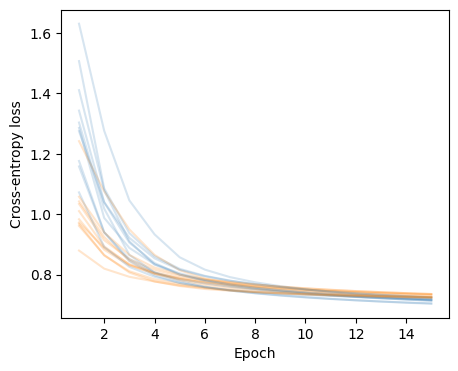

------------------------------ 
Training set:
Average log-likelihood = -5150.5 (31.1)
Average accuracy       = 70.2% (0.5%)
Average F1 score       = 60.0% (1.8%)
------------------------------ 
Validation set:
Average log-likelihood = -728.9 (5.0)
Average accuracy       = 70.1% (0.2%)
Average F1 score       = 59.9% (1.5%)
------------------------------ 
Test set:
Average log-likelihood = -1568.0 (10.1)
Average accuracy       = 68.3% (0.4%)
Average F1 score       = 57.5% (1.7%)
------------------------------ 
Training set:
Strong regularity = 0.304 (0.036)
Weak regularity   = 0.472 (0.024)
------------------------------ 
Validation set:
Strong regularity = 0.306 (0.031)
Weak regularity   = 0.469 (0.025)
------------------------------ 
Test set:
Strong regularity = 0.309 (0.035)
Weak regularity   = 0.477 (0.024)
------------------------------


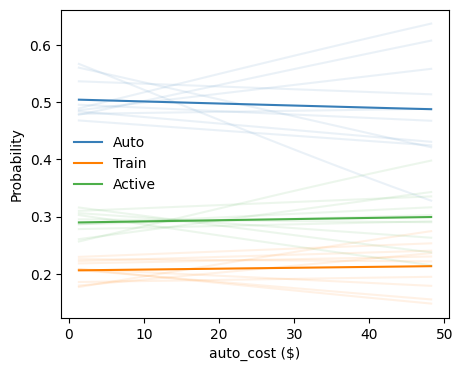

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4995.8 | acc = 71.5% | F1 = 63.4%
Validation set: LL = -711.2  | acc = 70.9% | F1 = 62.4%
Test set:       LL = -1534.7 | acc = 69.3% | F1 = 60.8%
Model 2 
Training set:   LL = -4987.3 | acc = 71.3% | F1 = 62.9%
Validation set: LL = -707.0  | acc = 70.9% | F1 = 62.2%
Test set:       LL = -1535.1 | acc = 69.5% | F1 = 60.6%
Model 3 
Training set:   LL = -4981.4 | acc = 71.4% | F1 = 63.5%
Validation set: LL = -705.1  | acc = 70.8% | F1 = 62.7%
Test set:       LL = -1530.0 | acc = 69.5% | F1 = 61.4%
Model 4 
Training set:   LL = -5003.8 | acc = 71.1% | F1 = 62.4%
Validation set: LL = -712.3  | acc = 70.5% | F1 = 61.2%
Test set:       LL = -1536.6 | acc = 69.0% | F1 = 59.5%
Model 5 
Training set:   LL = -4986.2 | acc = 71.6% | F1 = 64.0%
Validation set: LL = -707.7  | acc = 70.7% | F1 = 62.9%
Test set:       LL = -1526.2 | acc = 69.9% | F1 = 62.2%
Model 6 
Training set:   LL = -4988.5 | acc = 71.6% | F1 = 63.9%
Vali

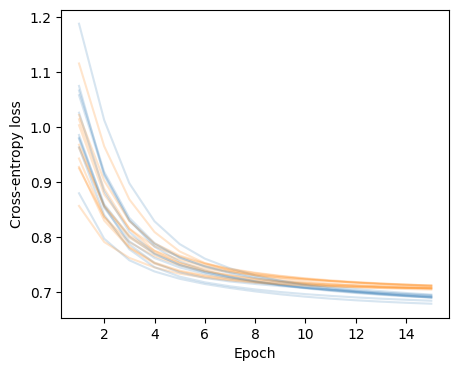

------------------------------ 
Training set:
Average log-likelihood = -4982.5 (20.6)
Average accuracy       = 71.5% (0.2%)
Average F1 score       = 63.6% (0.8%)
------------------------------ 
Validation set:
Average log-likelihood = -709.3 (2.6)
Average accuracy       = 70.8% (0.3%)
Average F1 score       = 62.7% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1532.3 (7.0)
Average accuracy       = 69.6% (0.3%)
Average F1 score       = 61.4% (1.0%)
------------------------------ 
Training set:
Strong regularity = 0.267 (0.031)
Weak regularity   = 0.345 (0.036)
------------------------------ 
Validation set:
Strong regularity = 0.271 (0.028)
Weak regularity   = 0.346 (0.036)
------------------------------ 
Test set:
Strong regularity = 0.268 (0.033)
Weak regularity   = 0.349 (0.039)
------------------------------


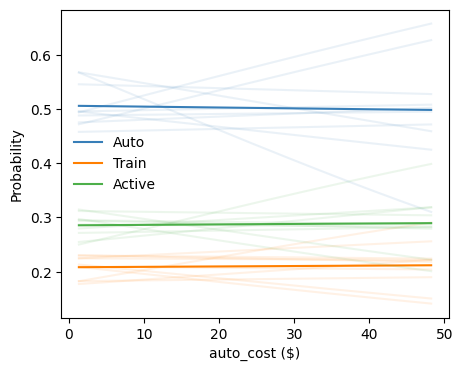

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4829.5 | acc = 72.6% | F1 = 65.8%
Validation set: LL = -694.3  | acc = 71.5% | F1 = 64.5%
Test set:       LL = -1489.4 | acc = 70.4% | F1 = 63.4%
Model 2 
Training set:   LL = -4832.0 | acc = 72.4% | F1 = 65.2%
Validation set: LL = -691.1  | acc = 71.9% | F1 = 64.6%
Test set:       LL = -1492.8 | acc = 70.8% | F1 = 63.4%
Model 3 
Training set:   LL = -4821.8 | acc = 72.4% | F1 = 65.5%
Validation set: LL = -689.5  | acc = 71.6% | F1 = 64.7%
Test set:       LL = -1487.6 | acc = 70.7% | F1 = 63.6%
Model 4 
Training set:   LL = -4841.5 | acc = 72.4% | F1 = 65.2%
Validation set: LL = -696.4  | acc = 71.4% | F1 = 63.8%
Test set:       LL = -1493.6 | acc = 70.2% | F1 = 62.3%
Model 5 
Training set:   LL = -4840.2 | acc = 72.5% | F1 = 65.5%
Validation set: LL = -690.3  | acc = 71.8% | F1 = 64.7%
Test set:       LL = -1487.7 | acc = 71.2% | F1 = 64.2%
Model 6 
Training set:   LL = -4828.5 | acc = 72.5% | F1 = 65.6%
Val

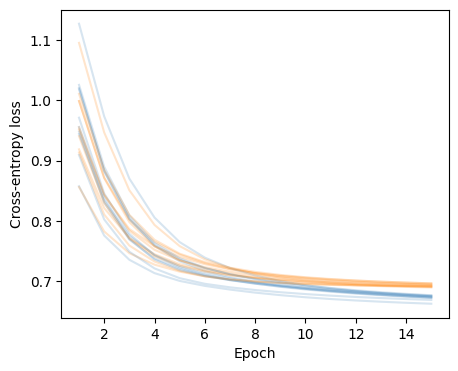

------------------------------ 
Training set:
Average log-likelihood = -4825.6 (18.7)
Average accuracy       = 72.5% (0.1%)
Average F1 score       = 65.5% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -692.8 (2.3)
Average accuracy       = 71.7% (0.2%)
Average F1 score       = 64.7% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1489.6 (6.5)
Average accuracy       = 70.6% (0.3%)
Average F1 score       = 63.5% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.753 (0.038)
Weak regularity   = 0.785 (0.040)
------------------------------ 
Validation set:
Strong regularity = 0.749 (0.039)
Weak regularity   = 0.782 (0.043)
------------------------------ 
Test set:
Strong regularity = 0.754 (0.036)
Weak regularity   = 0.786 (0.037)
------------------------------


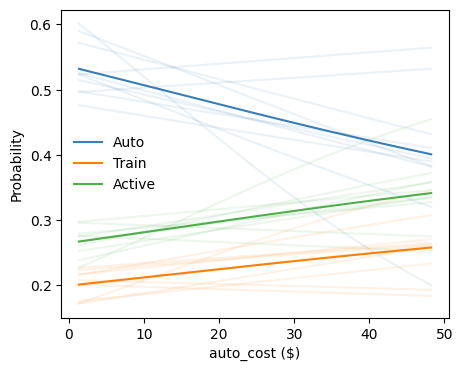

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4702.9 | acc = 73.2% | F1 = 67.1%
Validation set: LL = -685.4  | acc = 72.2% | F1 = 66.2%
Test set:       LL = -1446.9 | acc = 71.0% | F1 = 64.7%
Model 2 
Training set:   LL = -4700.9 | acc = 73.0% | F1 = 66.7%
Validation set: LL = -682.1  | acc = 72.7% | F1 = 66.4%
Test set:       LL = -1449.3 | acc = 71.2% | F1 = 64.8%
Model 3 
Training set:   LL = -4685.5 | acc = 72.9% | F1 = 66.8%
Validation set: LL = -680.6  | acc = 72.0% | F1 = 65.5%
Test set:       LL = -1442.2 | acc = 71.0% | F1 = 64.5%
Model 4 
Training set:   LL = -4706.1 | acc = 72.9% | F1 = 66.4%
Validation set: LL = -687.6  | acc = 72.1% | F1 = 65.3%
Test set:       LL = -1448.5 | acc = 70.9% | F1 = 64.1%
Model 5 
Training set:   LL = -4723.5 | acc = 72.8% | F1 = 66.5%
Validation set: LL = -680.3  | acc = 72.4% | F1 = 66.0%
Test set:       LL = -1446.4 | acc = 71.2% | F1 = 64.8%
Model 6 
Training set:   LL = -4709.0 | acc = 73.1% | F1 = 66.9%
Va

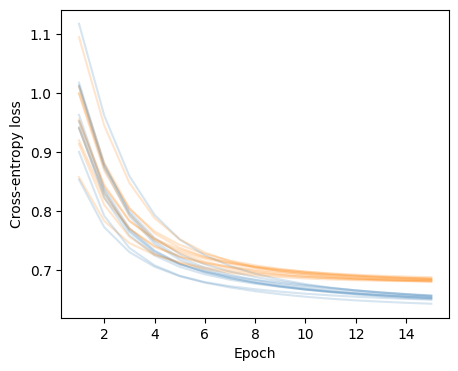

------------------------------ 
Training set:
Average log-likelihood = -4698.6 (19.6)
Average accuracy       = 73.0% (0.2%)
Average F1 score       = 66.8% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -683.2 (2.4)
Average accuracy       = 72.3% (0.3%)
Average F1 score       = 65.9% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1446.5 (5.9)
Average accuracy       = 71.1% (0.2%)
Average F1 score       = 64.8% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.991 (0.008)
Weak regularity   = 0.995 (0.006)
------------------------------ 
Validation set:
Strong regularity = 0.989 (0.009)
Weak regularity   = 0.993 (0.007)
------------------------------ 
Test set:
Strong regularity = 0.992 (0.007)
Weak regularity   = 0.995 (0.006)
------------------------------


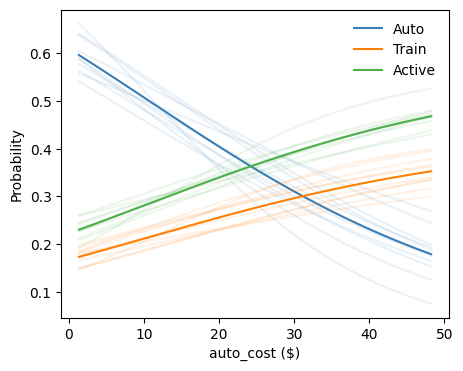

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -4685.2 | acc = 73.2% | F1 = 67.4%
Validation set: LL = -685.0  | acc = 72.3% | F1 = 66.6%
Test set:       LL = -1440.1 | acc = 70.8% | F1 = 64.6%
Model 2 
Training set:   LL = -4681.1 | acc = 73.5% | F1 = 67.9%
Validation set: LL = -682.4  | acc = 73.0% | F1 = 67.1%
Test set:       LL = -1441.7 | acc = 71.4% | F1 = 65.4%
Model 3 
Training set:   LL = -4664.6 | acc = 73.1% | F1 = 67.4%
Validation set: LL = -680.9  | acc = 72.3% | F1 = 66.4%
Test set:       LL = -1434.0 | acc = 71.3% | F1 = 65.2%
Model 4 
Training set:   LL = -4685.9 | acc = 73.2% | F1 = 67.2%
Validation set: LL = -687.8  | acc = 72.3% | F1 = 66.0%
Test set:       LL = -1440.8 | acc = 71.0% | F1 = 64.8%
Model 5 
Training set:   LL = -4705.5 | acc = 73.0% | F1 = 67.1%
Validation set: LL = -679.7  | acc = 72.6% | F1 = 66.6%
Test set:       LL = -1439.0 | acc = 71.7% | F1 = 65.7%
Model 6 
Training set:   LL = -4691.4 | acc = 73.2% | F1 = 67.3%
Val

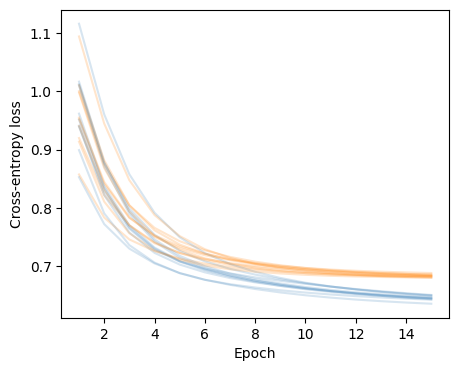

------------------------------ 
Training set:
Average log-likelihood = -4679.7 (19.9)
Average accuracy       = 73.2% (0.2%)
Average F1 score       = 67.4% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -683.0 (2.4)
Average accuracy       = 72.5% (0.4%)
Average F1 score       = 66.6% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1439.1 (5.8)
Average accuracy       = 71.3% (0.3%)
Average F1 score       = 65.3% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.997 (0.003)
Weak regularity   = 0.999 (0.002)
------------------------------ 
Validation set:
Strong regularity = 0.996 (0.005)
Weak regularity   = 0.998 (0.003)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 0.999 (0.002)
------------------------------


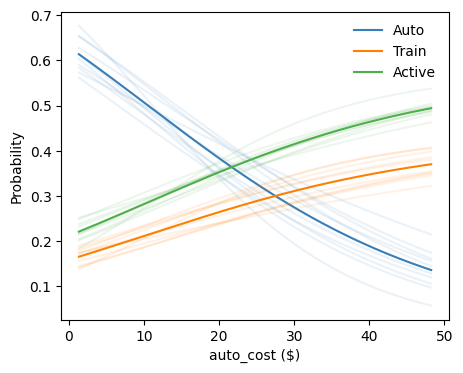

------------------------------ 
Model comparison:


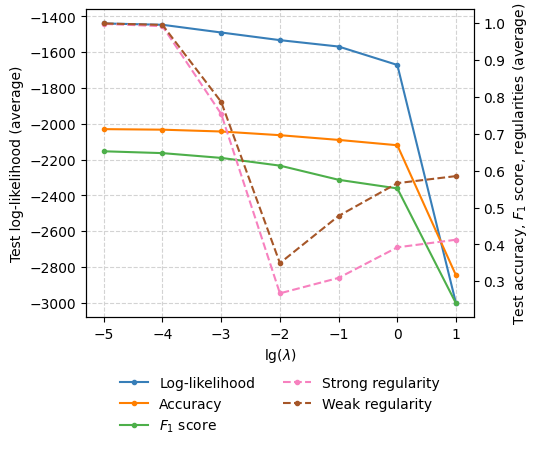

In [ ]:
# With norm
result(TasteNet, 15, 'PGR', [10**i for i in range(1, -6, -1)], 'norm')

### UGR

In [ ]:
# With sum
# result(TasteNet, 15, 'UGR', [10**i for i in range(1, -6, -1)])

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -5321.4 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -754.4  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1592.9 | acc = 67.8% | F1 = 54.8%
Model 2 
Training set:   LL = -5306.6 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -745.3  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1590.9 | acc = 67.8% | F1 = 54.8%
Model 3 
Training set:   LL = -5280.7 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -744.1  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1584.9 | acc = 67.8% | F1 = 54.8%
Model 4 
Training set:   LL = -5295.7 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -752.1  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1585.2 | acc = 67.8% | F1 = 54.8%
Model 5 
Training set:   LL = -5386.6 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -751.0  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1601.6 | acc = 67.8% | F1 = 54.8%
Model 6 
Training set:   LL = -5312.9 | acc = 69.3% | F1 = 56.7%
Valida

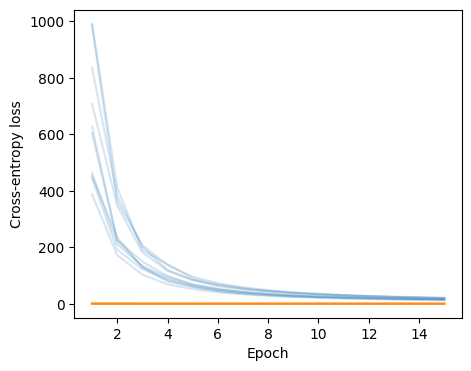

------------------------------ 
Training set:
Average log-likelihood = -5299.7 (49.5)
Average accuracy       = 69.4% (0.3%)
Average F1 score       = 57.3% (1.2%)
------------------------------ 
Validation set:
Average log-likelihood = -748.6 (6.3)
Average accuracy       = 69.8% (0.1%)
Average F1 score       = 57.8% (1.0%)
------------------------------ 
Test set:
Average log-likelihood = -1588.5 (11.4)
Average accuracy       = 67.9% (0.2%)
Average F1 score       = 55.3% (1.1%)
------------------------------ 
Training set:
Strong regularity = 0.422 (0.029)
Weak regularity   = 0.597 (0.029)
------------------------------ 
Validation set:
Strong regularity = 0.422 (0.025)
Weak regularity   = 0.597 (0.032)
------------------------------ 
Test set:
Strong regularity = 0.423 (0.030)
Weak regularity   = 0.594 (0.031)
------------------------------


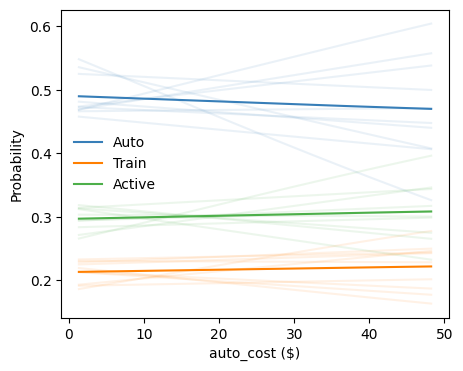

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -5320.5 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -754.2  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1592.8 | acc = 67.8% | F1 = 54.8%
Model 2 
Training set:   LL = -5305.3 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -745.1  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1590.8 | acc = 67.8% | F1 = 54.8%
Model 3 
Training set:   LL = -5279.8 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -744.0  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1584.8 | acc = 67.8% | F1 = 54.8%
Model 4 
Training set:   LL = -5294.3 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -751.9  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1585.0 | acc = 67.8% | F1 = 54.8%
Model 5 
Training set:   LL = -5385.0 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -750.8  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1601.3 | acc = 67.8% | F1 = 54.8%
Model 6 
Training set:   LL = -5311.9 | acc = 69.3% | F1 = 56.7%
Validat

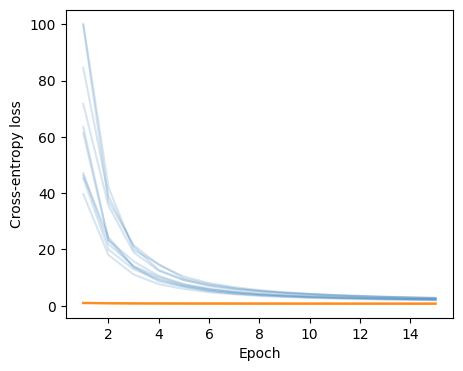

------------------------------ 
Training set:
Average log-likelihood = -5298.5 (49.3)
Average accuracy       = 69.4% (0.3%)
Average F1 score       = 57.3% (1.2%)
------------------------------ 
Validation set:
Average log-likelihood = -748.5 (6.3)
Average accuracy       = 69.8% (0.1%)
Average F1 score       = 57.8% (1.0%)
------------------------------ 
Test set:
Average log-likelihood = -1588.3 (11.3)
Average accuracy       = 67.9% (0.2%)
Average F1 score       = 55.3% (1.1%)
------------------------------ 
Training set:
Strong regularity = 0.421 (0.029)
Weak regularity   = 0.596 (0.029)
------------------------------ 
Validation set:
Strong regularity = 0.422 (0.025)
Weak regularity   = 0.597 (0.032)
------------------------------ 
Test set:
Strong regularity = 0.423 (0.030)
Weak regularity   = 0.593 (0.031)
------------------------------


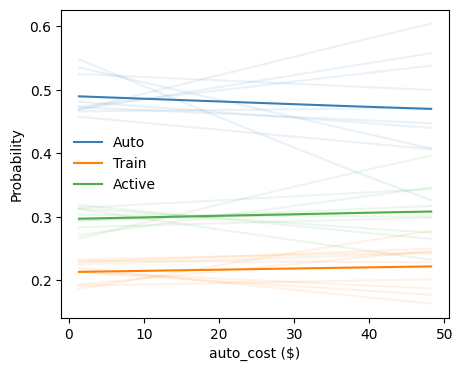

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -5311.1 | acc = 69.3% | F1 = 56.8%
Validation set: LL = -753.0  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1591.4 | acc = 67.8% | F1 = 54.9%
Model 2 
Training set:   LL = -5292.7 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -743.5  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1589.3 | acc = 67.8% | F1 = 54.8%
Model 3 
Training set:   LL = -5270.7 | acc = 69.3% | F1 = 56.8%
Validation set: LL = -742.7  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1583.5 | acc = 67.7% | F1 = 54.8%
Model 4 
Training set:   LL = -5282.0 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -750.2  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1583.3 | acc = 67.8% | F1 = 54.8%
Model 5 
Training set:   LL = -5368.4 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -748.8  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1598.4 | acc = 67.8% | F1 = 54.8%
Model 6 
Training set:   LL = -5302.8 | acc = 69.3% | F1 = 56.7%
Valid

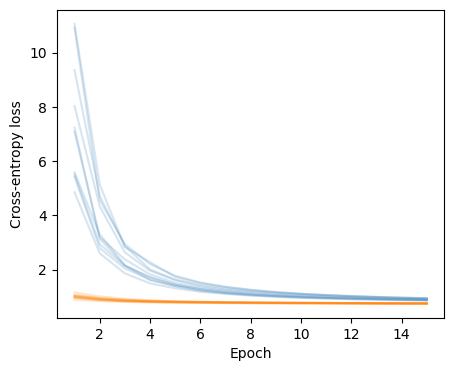

------------------------------ 
Training set:
Average log-likelihood = -5287.2 (47.8)
Average accuracy       = 69.4% (0.3%)
Average F1 score       = 57.3% (1.2%)
------------------------------ 
Validation set:
Average log-likelihood = -747.0 (6.2)
Average accuracy       = 69.8% (0.1%)
Average F1 score       = 57.8% (1.0%)
------------------------------ 
Test set:
Average log-likelihood = -1586.7 (11.2)
Average accuracy       = 67.9% (0.2%)
Average F1 score       = 55.3% (1.1%)
------------------------------ 
Training set:
Strong regularity = 0.415 (0.029)
Weak regularity   = 0.590 (0.030)
------------------------------ 
Validation set:
Strong regularity = 0.415 (0.026)
Weak regularity   = 0.590 (0.031)
------------------------------ 
Test set:
Strong regularity = 0.416 (0.029)
Weak regularity   = 0.586 (0.032)
------------------------------


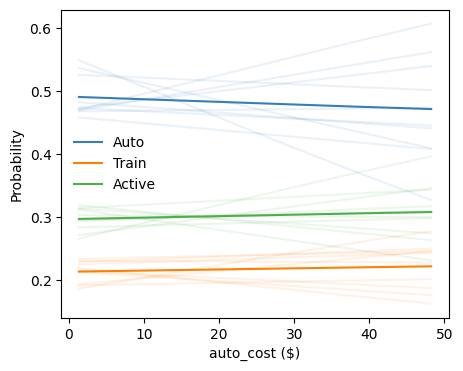

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -5240.1 | acc = 70.2% | F1 = 59.8%
Validation set: LL = -743.6  | acc = 70.1% | F1 = 59.9%
Test set:       LL = -1581.7 | acc = 68.3% | F1 = 57.4%
Model 2 
Training set:   LL = -5213.0 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -733.3  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1579.5 | acc = 67.8% | F1 = 54.8%
Model 3 
Training set:   LL = -5202.2 | acc = 69.9% | F1 = 59.2%
Validation set: LL = -732.8  | acc = 70.0% | F1 = 59.1%
Test set:       LL = -1573.3 | acc = 68.0% | F1 = 56.6%
Model 4 
Training set:   LL = -5204.1 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -739.2  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1573.0 | acc = 67.8% | F1 = 54.8%
Model 5 
Training set:   LL = -5265.9 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -737.1  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1580.6 | acc = 67.8% | F1 = 54.8%
Model 6 
Training set:   LL = -5228.0 | acc = 69.6% | F1 = 58.0%
Vali

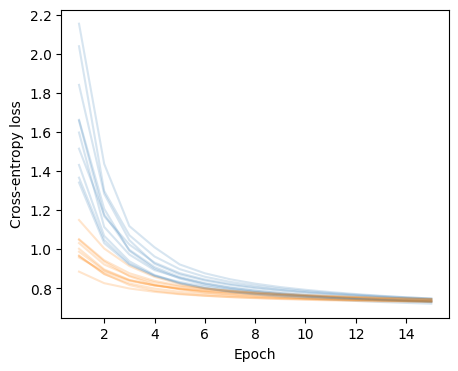

------------------------------ 
Training set:
Average log-likelihood = -5209.4 (39.3)
Average accuracy       = 69.8% (0.5%)
Average F1 score       = 58.8% (1.8%)
------------------------------ 
Validation set:
Average log-likelihood = -737.0 (5.3)
Average accuracy       = 69.9% (0.2%)
Average F1 score       = 58.9% (1.4%)
------------------------------ 
Test set:
Average log-likelihood = -1575.8 (10.4)
Average accuracy       = 68.1% (0.3%)
Average F1 score       = 56.5% (1.5%)
------------------------------ 
Training set:
Strong regularity = 0.356 (0.035)
Weak regularity   = 0.539 (0.027)
------------------------------ 
Validation set:
Strong regularity = 0.356 (0.030)
Weak regularity   = 0.536 (0.029)
------------------------------ 
Test set:
Strong regularity = 0.360 (0.037)
Weak regularity   = 0.540 (0.026)
------------------------------


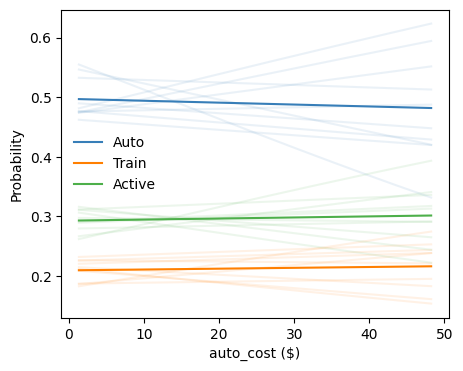

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -5072.3 | acc = 70.9% | F1 = 61.9%
Validation set: LL = -721.0  | acc = 70.2% | F1 = 60.9%
Test set:       LL = -1555.1 | acc = 68.5% | F1 = 58.5%
Model 2 
Training set:   LL = -5062.5 | acc = 71.1% | F1 = 62.1%
Validation set: LL = -715.9  | acc = 70.6% | F1 = 61.3%
Test set:       LL = -1555.3 | acc = 69.2% | F1 = 59.7%
Model 3 
Training set:   LL = -5059.2 | acc = 71.2% | F1 = 62.9%
Validation set: LL = -714.6  | acc = 71.0% | F1 = 62.8%
Test set:       LL = -1550.5 | acc = 69.0% | F1 = 60.3%
Model 4 
Training set:   LL = -5076.8 | acc = 70.5% | F1 = 60.7%
Validation set: LL = -721.5  | acc = 70.3% | F1 = 60.2%
Test set:       LL = -1554.6 | acc = 68.8% | F1 = 58.4%
Model 5 
Training set:   LL = -5071.4 | acc = 71.3% | F1 = 63.4%
Validation set: LL = -716.9  | acc = 70.5% | F1 = 62.5%
Test set:       LL = -1546.7 | acc = 69.3% | F1 = 61.0%
Model 6 
Training set:   LL = -5067.6 | acc = 71.1% | F1 = 62.5%
Val

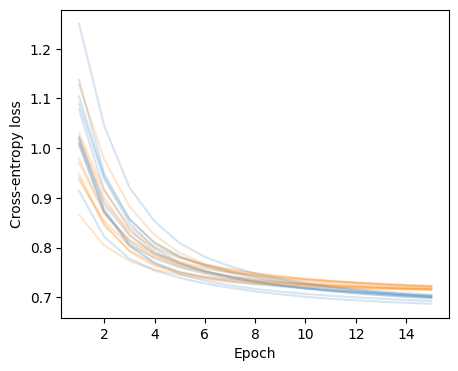

------------------------------ 
Training set:
Average log-likelihood = -5059.0 (22.5)
Average accuracy       = 71.2% (0.4%)
Average F1 score       = 62.8% (1.2%)
------------------------------ 
Validation set:
Average log-likelihood = -718.7 (2.9)
Average accuracy       = 70.6% (0.2%)
Average F1 score       = 62.1% (1.1%)
------------------------------ 
Test set:
Average log-likelihood = -1552.0 (7.5)
Average accuracy       = 69.2% (0.4%)
Average F1 score       = 60.3% (1.4%)
------------------------------ 
Training set:
Strong regularity = 0.211 (0.039)
Weak regularity   = 0.326 (0.035)
------------------------------ 
Validation set:
Strong regularity = 0.216 (0.041)
Weak regularity   = 0.329 (0.041)
------------------------------ 
Test set:
Strong regularity = 0.213 (0.037)
Weak regularity   = 0.330 (0.032)
------------------------------


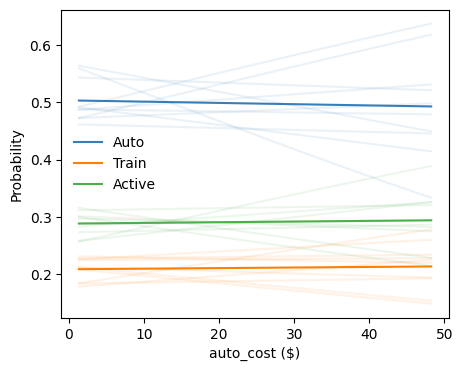

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4933.9 | acc = 72.3% | F1 = 65.3%
Validation set: LL = -704.5  | acc = 71.7% | F1 = 64.8%
Test set:       LL = -1523.2 | acc = 70.5% | F1 = 63.3%
Model 2 
Training set:   LL = -4931.9 | acc = 72.3% | F1 = 65.0%
Validation set: LL = -701.3  | acc = 71.9% | F1 = 64.8%
Test set:       LL = -1525.7 | acc = 70.5% | F1 = 62.9%
Model 3 
Training set:   LL = -4928.7 | acc = 72.4% | F1 = 65.4%
Validation set: LL = -700.2  | acc = 71.5% | F1 = 64.5%
Test set:       LL = -1523.0 | acc = 70.5% | F1 = 63.3%
Model 4 
Training set:   LL = -4945.7 | acc = 72.2% | F1 = 64.9%
Validation set: LL = -706.4  | acc = 71.6% | F1 = 64.1%
Test set:       LL = -1528.4 | acc = 70.0% | F1 = 62.0%
Model 5 
Training set:   LL = -4933.9 | acc = 72.4% | F1 = 65.5%
Validation set: LL = -700.8  | acc = 71.6% | F1 = 64.6%
Test set:       LL = -1518.1 | acc = 70.5% | F1 = 63.4%
Model 6 
Training set:   LL = -4926.4 | acc = 72.4% | F1 = 65.5%
Va

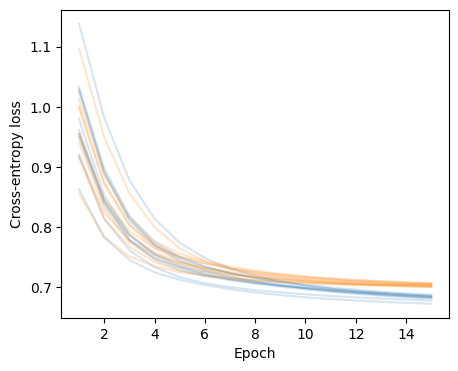

------------------------------ 
Training set:
Average log-likelihood = -4928.3 (16.8)
Average accuracy       = 72.3% (0.1%)
Average F1 score       = 65.3% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -703.4 (2.1)
Average accuracy       = 71.6% (0.2%)
Average F1 score       = 64.6% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1523.4 (6.7)
Average accuracy       = 70.4% (0.2%)
Average F1 score       = 63.1% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.337 (0.043)
Weak regularity   = 0.398 (0.036)
------------------------------ 
Validation set:
Strong regularity = 0.337 (0.043)
Weak regularity   = 0.397 (0.035)
------------------------------ 
Test set:
Strong regularity = 0.342 (0.044)
Weak regularity   = 0.408 (0.032)
------------------------------


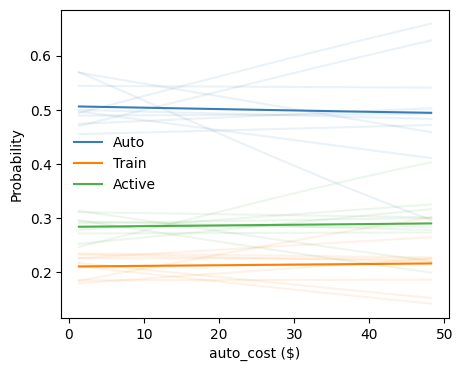

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -4762.7 | acc = 73.0% | F1 = 66.8%
Validation set: LL = -688.7  | acc = 71.9% | F1 = 65.5%
Test set:       LL = -1467.3 | acc = 70.9% | F1 = 64.4%
Model 2 
Training set:   LL = -4767.6 | acc = 72.9% | F1 = 66.4%
Validation set: LL = -686.0  | acc = 72.3% | F1 = 65.6%
Test set:       LL = -1472.8 | acc = 71.2% | F1 = 64.5%
Model 3 
Training set:   LL = -4759.8 | acc = 73.0% | F1 = 66.7%
Validation set: LL = -684.6  | acc = 72.0% | F1 = 65.5%
Test set:       LL = -1468.7 | acc = 70.7% | F1 = 64.1%
Model 4 
Training set:   LL = -4776.9 | acc = 72.8% | F1 = 66.1%
Validation set: LL = -691.3  | acc = 71.9% | F1 = 65.0%
Test set:       LL = -1473.2 | acc = 70.5% | F1 = 63.4%
Model 5 
Training set:   LL = -4778.6 | acc = 72.6% | F1 = 66.0%
Validation set: LL = -684.5  | acc = 72.1% | F1 = 65.6%
Test set:       LL = -1466.6 | acc = 71.2% | F1 = 64.7%
Model 6 
Training set:   LL = -4763.9 | acc = 72.9% | F1 = 66.6%
Val

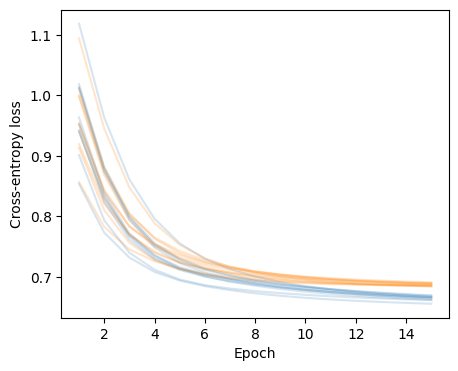

------------------------------ 
Training set:
Average log-likelihood = -4763.8 (17.5)
Average accuracy       = 72.9% (0.2%)
Average F1 score       = 66.5% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -687.4 (2.2)
Average accuracy       = 72.0% (0.1%)
Average F1 score       = 65.5% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1469.5 (6.3)
Average accuracy       = 71.0% (0.3%)
Average F1 score       = 64.3% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.922 (0.032)
Weak regularity   = 0.935 (0.028)
------------------------------ 
Validation set:
Strong regularity = 0.924 (0.030)
Weak regularity   = 0.935 (0.026)
------------------------------ 
Test set:
Strong regularity = 0.929 (0.030)
Weak regularity   = 0.941 (0.026)
------------------------------


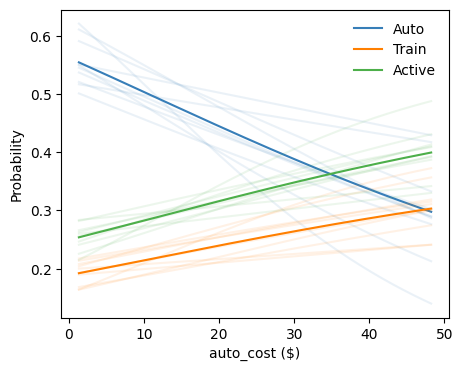

------------------------------ 
Model comparison:


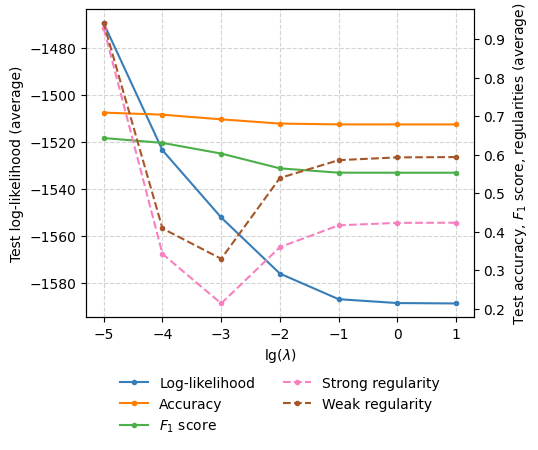

In [ ]:
# With norm
result(TasteNet, 15, 'UGR', [10**i for i in range(1, -6, -1)], 'norm')

### LGR

In [ ]:
# With sum
# result(TasteNet, 15, 'LGR', [10**i for i in range(1, -6, -1)])

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -5917.8 | acc = 69.2% | F1 = 56.7%
Validation set: LL = -843.5  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1716.5 | acc = 67.8% | F1 = 54.8%
Model 2 
Training set:   LL = -5852.4 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -819.6  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1710.7 | acc = 67.8% | F1 = 54.8%
Model 3 
Training set:   LL = -6100.5 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -851.0  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1764.0 | acc = 67.8% | F1 = 54.8%
Model 4 
Training set:   LL = -5738.4 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -819.3  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1686.2 | acc = 67.8% | F1 = 54.8%
Model 5 
Training set:   LL = -6341.1 | acc = 66.8% | F1 = 57.0%
Validation set: LL = -893.3  | acc = 68.5% | F1 = 59.0%
Test set:       LL = -1832.2 | acc = 64.8% | F1 = 55.0%
Model 6 
Training set:   LL = -5877.7 | acc = 69.3% | F1 = 56.7%
Valida

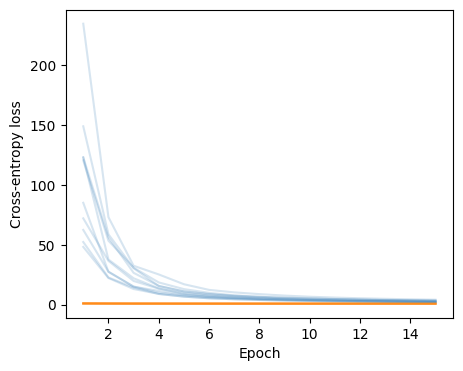

------------------------------ 
Training set:
Average log-likelihood = -5882.6 (209.1)
Average accuracy       = 69.0% (0.7%)
Average F1 score       = 56.8% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -830.3 (30.5)
Average accuracy       = 69.5% (0.4%)
Average F1 score       = 57.4% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1714.4 (53.6)
Average accuracy       = 67.5% (0.9%)
Average F1 score       = 54.8% (0.1%)
------------------------------ 
Training set:
Strong regularity = 0.458 (0.029)
Weak regularity   = 0.567 (0.032)
------------------------------ 
Validation set:
Strong regularity = 0.456 (0.036)
Weak regularity   = 0.564 (0.036)
------------------------------ 
Test set:
Strong regularity = 0.458 (0.024)
Weak regularity   = 0.568 (0.035)
------------------------------


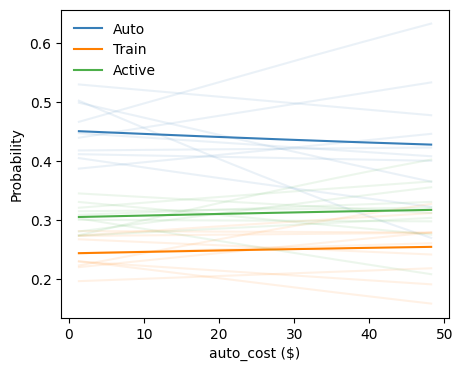

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -5807.0 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -827.0  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1690.6 | acc = 67.8% | F1 = 54.8%
Model 2 
Training set:   LL = -5676.3 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -794.2  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1669.4 | acc = 67.8% | F1 = 54.8%
Model 3 
Training set:   LL = -5990.3 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -836.7  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1736.7 | acc = 67.8% | F1 = 54.8%
Model 4 
Training set:   LL = -5633.8 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -803.2  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1664.1 | acc = 67.8% | F1 = 54.8%
Model 5 
Training set:   LL = -6183.5 | acc = 68.4% | F1 = 56.6%
Validation set: LL = -869.9  | acc = 69.2% | F1 = 57.4%
Test set:       LL = -1791.2 | acc = 66.7% | F1 = 54.5%
Model 6 
Training set:   LL = -5808.0 | acc = 69.3% | F1 = 56.7%
Validat

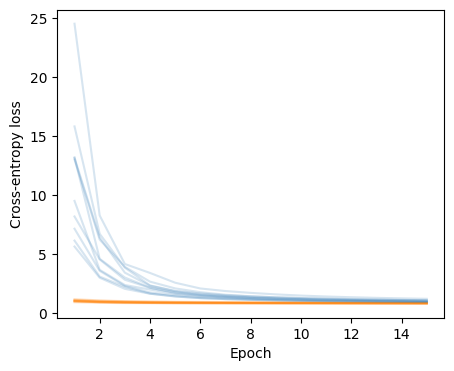

------------------------------ 
Training set:
Average log-likelihood = -5753.1 (192.7)
Average accuracy       = 69.2% (0.3%)
Average F1 score       = 56.7% (0.0%)
------------------------------ 
Validation set:
Average log-likelihood = -811.3 (27.2)
Average accuracy       = 69.7% (0.2%)
Average F1 score       = 57.3% (0.0%)
------------------------------ 
Test set:
Average log-likelihood = -1683.9 (46.2)
Average accuracy       = 67.7% (0.3%)
Average F1 score       = 54.8% (0.1%)
------------------------------ 
Training set:
Strong regularity = 0.448 (0.030)
Weak regularity   = 0.559 (0.031)
------------------------------ 
Validation set:
Strong regularity = 0.446 (0.035)
Weak regularity   = 0.556 (0.031)
------------------------------ 
Test set:
Strong regularity = 0.448 (0.024)
Weak regularity   = 0.560 (0.033)
------------------------------


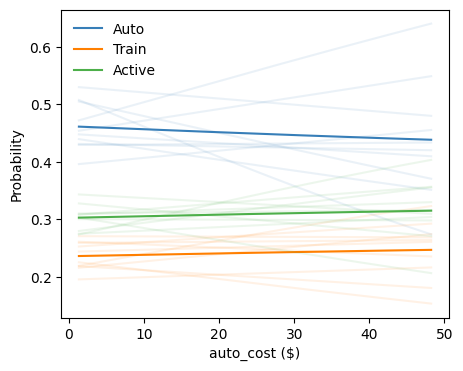

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -5450.1 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -774.9  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1619.5 | acc = 67.8% | F1 = 54.8%
Model 2 
Training set:   LL = -5313.6 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -746.1  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1595.7 | acc = 67.8% | F1 = 54.8%
Model 3 
Training set:   LL = -5512.5 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -774.6  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1628.6 | acc = 67.8% | F1 = 54.8%
Model 4 
Training set:   LL = -5298.3 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -754.0  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1591.8 | acc = 67.8% | F1 = 54.8%
Model 5 
Training set:   LL = -5608.6 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -783.9  | acc = 69.6% | F1 = 57.2%
Test set:       LL = -1651.1 | acc = 67.8% | F1 = 54.8%
Model 6 
Training set:   LL = -5468.8 | acc = 69.3% | F1 = 56.7%
Valid

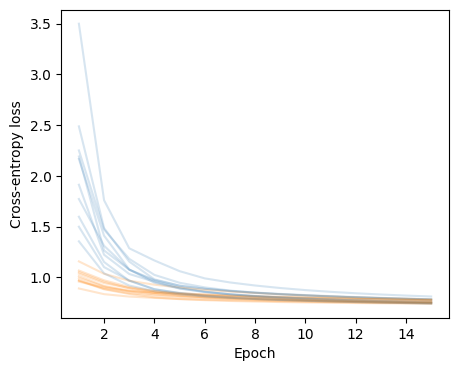

------------------------------ 
Training set:
Average log-likelihood = -5385.7 (112.3)
Average accuracy       = 69.3% (0.0%)
Average F1 score       = 56.7% (0.0%)
------------------------------ 
Validation set:
Average log-likelihood = -760.5 (14.8)
Average accuracy       = 69.7% (0.0%)
Average F1 score       = 57.3% (0.0%)
------------------------------ 
Test set:
Average log-likelihood = -1607.4 (21.4)
Average accuracy       = 67.8% (0.0%)
Average F1 score       = 54.8% (0.0%)
------------------------------ 
Training set:
Strong regularity = 0.394 (0.040)
Weak regularity   = 0.500 (0.032)
------------------------------ 
Validation set:
Strong regularity = 0.397 (0.040)
Weak regularity   = 0.499 (0.035)
------------------------------ 
Test set:
Strong regularity = 0.395 (0.033)
Weak regularity   = 0.502 (0.030)
------------------------------


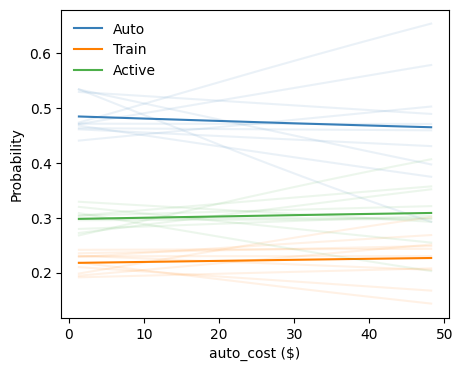

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -5111.2 | acc = 70.4% | F1 = 60.4%
Validation set: LL = -726.1  | acc = 70.3% | F1 = 60.4%
Test set:       LL = -1564.1 | acc = 68.5% | F1 = 57.7%
Model 2 
Training set:   LL = -5092.0 | acc = 70.4% | F1 = 60.3%
Validation set: LL = -718.9  | acc = 70.2% | F1 = 59.8%
Test set:       LL = -1559.9 | acc = 68.7% | F1 = 58.1%
Model 3 
Training set:   LL = -5106.4 | acc = 70.6% | F1 = 60.7%
Validation set: LL = -720.4  | acc = 70.2% | F1 = 60.4%
Test set:       LL = -1559.6 | acc = 68.4% | F1 = 57.8%
Model 4 
Training set:   LL = -5093.5 | acc = 70.4% | F1 = 60.2%
Validation set: LL = -723.9  | acc = 70.4% | F1 = 59.9%
Test set:       LL = -1558.6 | acc = 68.2% | F1 = 57.1%
Model 5 
Training set:   LL = -5152.8 | acc = 70.6% | F1 = 60.6%
Validation set: LL = -724.9  | acc = 70.6% | F1 = 60.6%
Test set:       LL = -1560.9 | acc = 68.5% | F1 = 57.9%
Model 6 
Training set:   LL = -5115.8 | acc = 70.4% | F1 = 60.6%
Vali

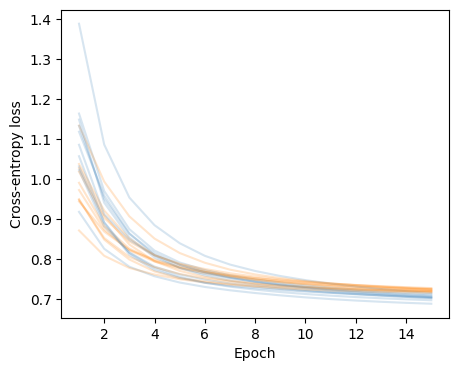

------------------------------ 
Training set:
Average log-likelihood = -5092.7 (34.4)
Average accuracy       = 70.8% (0.5%)
Average F1 score       = 61.6% (1.5%)
------------------------------ 
Validation set:
Average log-likelihood = -722.2 (3.5)
Average accuracy       = 70.5% (0.3%)
Average F1 score       = 61.2% (1.4%)
------------------------------ 
Test set:
Average log-likelihood = -1558.4 (8.2)
Average accuracy       = 68.8% (0.5%)
Average F1 score       = 59.0% (1.7%)
------------------------------ 
Training set:
Strong regularity = 0.227 (0.049)
Weak regularity   = 0.304 (0.042)
------------------------------ 
Validation set:
Strong regularity = 0.231 (0.050)
Weak regularity   = 0.303 (0.042)
------------------------------ 
Test set:
Strong regularity = 0.229 (0.047)
Weak regularity   = 0.308 (0.041)
------------------------------


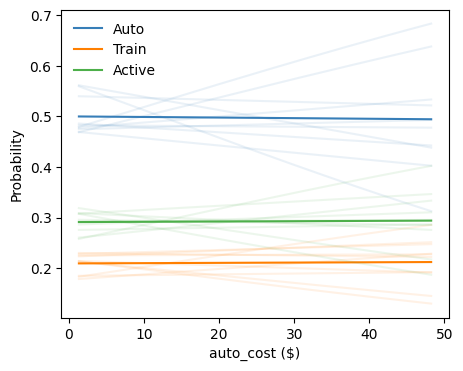

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4939.7 | acc = 72.3% | F1 = 65.2%
Validation set: LL = -704.9  | acc = 71.6% | F1 = 64.6%
Test set:       LL = -1524.4 | acc = 70.2% | F1 = 63.0%
Model 2 
Training set:   LL = -4934.2 | acc = 72.2% | F1 = 65.0%
Validation set: LL = -701.6  | acc = 71.9% | F1 = 64.9%
Test set:       LL = -1525.0 | acc = 70.2% | F1 = 62.7%
Model 3 
Training set:   LL = -4933.5 | acc = 72.2% | F1 = 65.1%
Validation set: LL = -699.9  | acc = 71.6% | F1 = 64.6%
Test set:       LL = -1522.8 | acc = 70.2% | F1 = 62.8%
Model 4 
Training set:   LL = -4949.5 | acc = 72.2% | F1 = 64.8%
Validation set: LL = -706.5  | acc = 71.6% | F1 = 64.1%
Test set:       LL = -1528.1 | acc = 70.1% | F1 = 62.1%
Model 5 
Training set:   LL = -4940.3 | acc = 72.4% | F1 = 65.4%
Validation set: LL = -701.6  | acc = 71.2% | F1 = 64.3%
Test set:       LL = -1517.2 | acc = 70.5% | F1 = 63.4%
Model 6 
Training set:   LL = -4932.4 | acc = 72.2% | F1 = 65.1%
Val

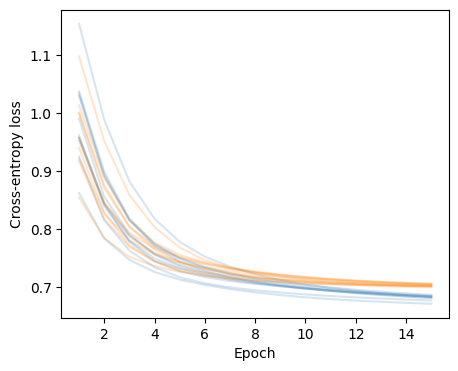

------------------------------ 
Training set:
Average log-likelihood = -4931.4 (18.1)
Average accuracy       = 72.2% (0.1%)
Average F1 score       = 65.2% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -703.4 (2.0)
Average accuracy       = 71.5% (0.3%)
Average F1 score       = 64.5% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1522.9 (6.7)
Average accuracy       = 70.3% (0.2%)
Average F1 score       = 63.0% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.296 (0.041)
Weak regularity   = 0.348 (0.038)
------------------------------ 
Validation set:
Strong regularity = 0.296 (0.046)
Weak regularity   = 0.346 (0.042)
------------------------------ 
Test set:
Strong regularity = 0.299 (0.037)
Weak regularity   = 0.352 (0.037)
------------------------------


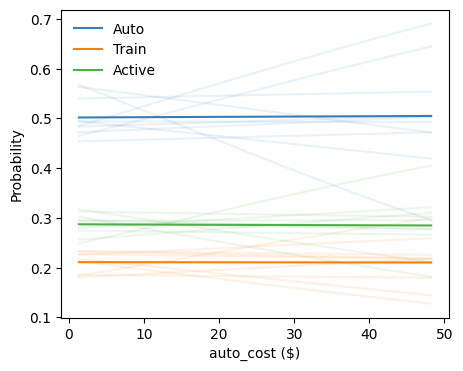

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4753.8 | acc = 73.0% | F1 = 66.9%
Validation set: LL = -687.6  | acc = 72.2% | F1 = 66.1%
Test set:       LL = -1463.5 | acc = 71.0% | F1 = 64.7%
Model 2 
Training set:   LL = -4756.9 | acc = 72.9% | F1 = 66.6%
Validation set: LL = -684.9  | acc = 72.3% | F1 = 65.8%
Test set:       LL = -1467.4 | acc = 71.0% | F1 = 64.5%
Model 3 
Training set:   LL = -4748.7 | acc = 72.9% | F1 = 66.6%
Validation set: LL = -682.9  | acc = 71.7% | F1 = 65.2%
Test set:       LL = -1463.5 | acc = 70.5% | F1 = 64.1%
Model 4 
Training set:   LL = -4766.0 | acc = 72.9% | F1 = 66.3%
Validation set: LL = -689.7  | acc = 71.8% | F1 = 65.1%
Test set:       LL = -1468.4 | acc = 70.9% | F1 = 64.2%
Model 5 
Training set:   LL = -4770.1 | acc = 72.7% | F1 = 66.3%
Validation set: LL = -683.8  | acc = 72.0% | F1 = 65.7%
Test set:       LL = -1461.8 | acc = 71.0% | F1 = 64.7%
Model 6 
Training set:   LL = -4755.8 | acc = 72.9% | F1 = 66.6%
Va

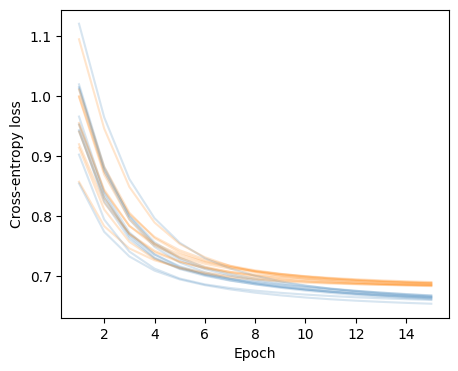

------------------------------ 
Training set:
Average log-likelihood = -4753.5 (17.6)
Average accuracy       = 72.9% (0.1%)
Average F1 score       = 66.6% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -686.1 (2.2)
Average accuracy       = 72.0% (0.2%)
Average F1 score       = 65.6% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1464.7 (6.1)
Average accuracy       = 71.0% (0.2%)
Average F1 score       = 64.5% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.936 (0.030)
Weak regularity   = 0.947 (0.026)
------------------------------ 
Validation set:
Strong regularity = 0.940 (0.028)
Weak regularity   = 0.948 (0.024)
------------------------------ 
Test set:
Strong regularity = 0.941 (0.027)
Weak regularity   = 0.951 (0.023)
------------------------------


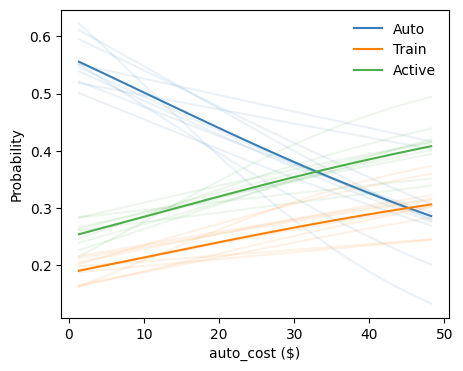

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -4690.1 | acc = 73.2% | F1 = 67.4%
Validation set: LL = -684.9  | acc = 72.5% | F1 = 66.7%
Test set:       LL = -1441.7 | acc = 70.9% | F1 = 64.8%
Model 2 
Training set:   LL = -4686.2 | acc = 73.4% | F1 = 67.7%
Validation set: LL = -682.1  | acc = 72.7% | F1 = 66.7%
Test set:       LL = -1443.4 | acc = 71.4% | F1 = 65.3%
Model 3 
Training set:   LL = -4670.2 | acc = 73.2% | F1 = 67.4%
Validation set: LL = -680.4  | acc = 72.5% | F1 = 66.5%
Test set:       LL = -1436.0 | acc = 71.2% | F1 = 65.0%
Model 4 
Training set:   LL = -4691.2 | acc = 73.1% | F1 = 67.0%
Validation set: LL = -687.4  | acc = 72.1% | F1 = 65.7%
Test set:       LL = -1442.6 | acc = 71.0% | F1 = 64.7%
Model 5 
Training set:   LL = -4710.2 | acc = 73.0% | F1 = 67.0%
Validation set: LL = -679.9  | acc = 72.5% | F1 = 66.5%
Test set:       LL = -1440.5 | acc = 71.6% | F1 = 65.7%
Model 6 
Training set:   LL = -4696.1 | acc = 73.1% | F1 = 67.2%
Val

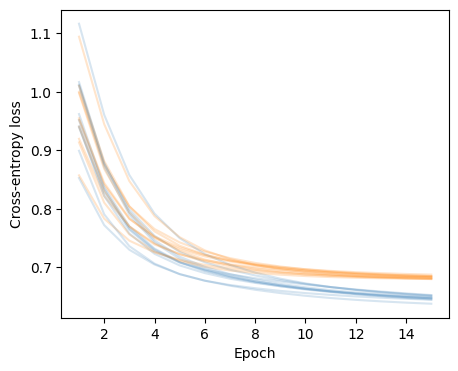

------------------------------ 
Training set:
Average log-likelihood = -4684.8 (19.7)
Average accuracy       = 73.2% (0.2%)
Average F1 score       = 67.3% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -682.9 (2.4)
Average accuracy       = 72.5% (0.4%)
Average F1 score       = 66.5% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -1440.8 (5.8)
Average accuracy       = 71.2% (0.3%)
Average F1 score       = 65.2% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.996 (0.005)
Weak regularity   = 0.998 (0.003)
------------------------------ 
Validation set:
Strong regularity = 0.995 (0.007)
Weak regularity   = 0.997 (0.006)
------------------------------ 
Test set:
Strong regularity = 0.997 (0.004)
Weak regularity   = 0.998 (0.003)
------------------------------


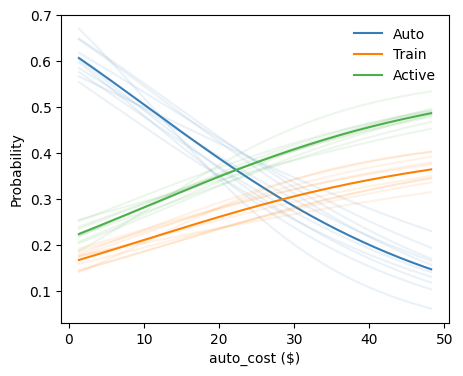

------------------------------ 
Model comparison:


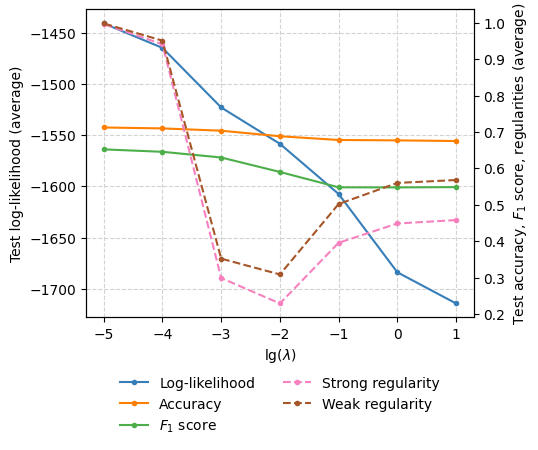

In [ ]:
# With norm
result(TasteNet, 15, 'LGR', [10**i for i in range(1, -6, -1)], 'norm')

# Final results

In [ ]:
weights = np.array([2/val_size, .5, .5, 1, 1])
scores = results_val.multiply(weights, axis=0).sum()
l_col = []
for model in ['DNN', 'TasteNet']:
    l_col.append(model)
    for GR in ['PGR', 'UGR', 'LGR']:
        l_col.append(scores[scores.index.str.startswith(f'{model}, norm-{GR}')].idxmax())
l_col.append('MNL')

In [ ]:
results_train = results_train[l_col]
results_val = results_val[l_col].iloc[:5]
results_test = results_test[l_col]

results_train_std = results_train_std[l_col]
results_val_std = results_val_std[l_col]
results_test_std = results_test_std[l_col]

In [ ]:
results_train.to_csv(f'{path}/Regularity_results/10K_Chicago_norm_train.csv')
results_val.to_csv(f'{path}/Regularity_results/10K_Chicago_norm_val.csv')
results_test.to_csv(f'{path}/Regularity_results/10K_Chicago_norm_test.csv')

results_train_std.to_csv(f'{path}/Regularity_results/10K_Chicago_train_norm_std.csv')
results_val_std.to_csv(f'{path}/Regularity_results/10K_Chicago_val_norm_std.csv')
results_test_std.to_csv(f'{path}/Regularity_results/10K_Chicago_test_norm_std.csv')

In [ ]:
results_train.iloc[0] = results_train.iloc[0].round(1)
results_val.iloc[0] = results_val.iloc[0].round(1)
results_test.iloc[0] = results_test.iloc[0].round(1)

In [ ]:
df_train = results_train.round(3).astype(str).add(' (').add(results_train_std.round(3).astype(str)).add(')')
df_val = results_val.round(3).astype(str).add(' (').add(results_val_std.round(3).astype(str)).add(')')
df_test = results_test.round(3).astype(str).add(' (').add(results_test_std.round(3).astype(str)).add(')')

In [ ]:
print(df_train.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, norm-PGR (0.0001) & DNN, norm-UGR (0.0001) & DNN, norm-LGR (0.0001) & TasteNet & TasteNet, norm-PGR (1e-05) & TasteNet, norm-UGR (1e-05) & TasteNet, norm-LGR (1e-05) & MNL \\
\midrule
Log-likelihood & -4272.6 (13.223) & -4282.9 (12.231) & -4333.2 (14.33) & -4303.7 (11.955) & -4677.8 (19.891) & -4679.7 (19.882) & -4763.8 (17.509) & -4684.8 (19.682) & -4710.2 (0) \\
Accuracy & 0.752 (0.002) & 0.75 (0.002) & 0.745 (0.002) & 0.748 (0.001) & 0.732 (0.002) & 0.732 (0.002) & 0.729 (0.002) & 0.732 (0.002) & 0.731 (0) \\
F1 score & 0.717 (0.004) & 0.713 (0.004) & 0.7 (0.005) & 0.706 (0.005) & 0.675 (0.004) & 0.674 (0.004) & 0.665 (0.004) & 0.673 (0.004) & 0.681 (0) \\
Strong regularity & 0.889 (0.061) & 0.856 (0.063) & 0.704 (0.044) & 0.813 (0.063) & 0.997 (0.003) & 0.997 (0.003) & 0.922 (0.032) & 0.996 (0.005) & 0.998 (0) \\
Weak regularity & 0.927 (0.058) & 0.898 (0.062) & 0.761 (0.046) & 0.855 (0.065) & 0.999 (0.002) & 0.999 (0.002) & 0.935 

In [ ]:
print(df_val.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, norm-PGR (0.0001) & DNN, norm-UGR (0.0001) & DNN, norm-LGR (0.0001) & TasteNet & TasteNet, norm-PGR (1e-05) & TasteNet, norm-UGR (1e-05) & TasteNet, norm-LGR (1e-05) & MNL \\
\midrule
Log-likelihood & -633.5 (2.518) & -633.3 (2.414) & -635.9 (2.676) & -633.3 (2.989) & -683.0 (2.442) & -683.0 (2.421) & -687.4 (2.236) & -682.9 (2.366) & -693.8 (0) \\
Accuracy & 0.739 (0.004) & 0.741 (0.004) & 0.741 (0.003) & 0.741 (0.003) & 0.726 (0.004) & 0.725 (0.004) & 0.72 (0.001) & 0.725 (0.004) & 0.737 (0) \\
F1 score & 0.702 (0.005) & 0.702 (0.005) & 0.696 (0.006) & 0.699 (0.005) & 0.668 (0.007) & 0.666 (0.007) & 0.655 (0.003) & 0.665 (0.006) & 0.69 (0) \\
Strong regularity & 0.879 (0.057) & 0.846 (0.058) & 0.701 (0.044) & 0.803 (0.061) & 0.997 (0.005) & 0.996 (0.005) & 0.924 (0.03) & 0.995 (0.007) & 1.0 (0) \\
Weak regularity & 0.928 (0.056) & 0.9 (0.057) & 0.766 (0.046) & 0.858 (0.062) & 0.998 (0.003) & 0.998 (0.003) & 0.935 (0.026) & 0.997 (0.0

In [ ]:
print(df_test.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, norm-PGR (0.0001) & DNN, norm-UGR (0.0001) & DNN, norm-LGR (0.0001) & TasteNet & TasteNet, norm-PGR (1e-05) & TasteNet, norm-UGR (1e-05) & TasteNet, norm-LGR (1e-05) & MNL \\
\midrule
Log-likelihood & -1351.7 (4.78) & -1353.9 (5.018) & -1362.0 (3.11) & -1354.0 (4.451) & -1438.3 (5.834) & -1439.1 (5.836) & -1469.5 (6.287) & -1440.8 (5.804) & -1426.3 (0) \\
Accuracy & 0.729 (0.003) & 0.729 (0.004) & 0.725 (0.004) & 0.727 (0.003) & 0.713 (0.003) & 0.713 (0.003) & 0.71 (0.003) & 0.712 (0.003) & 0.718 (0) \\
F1 score & 0.691 (0.006) & 0.688 (0.007) & 0.677 (0.009) & 0.683 (0.007) & 0.654 (0.006) & 0.653 (0.005) & 0.643 (0.005) & 0.652 (0.005) & 0.669 (0) \\
Strong regularity & 0.889 (0.066) & 0.857 (0.069) & 0.706 (0.051) & 0.815 (0.068) & 0.998 (0.002) & 0.998 (0.002) & 0.929 (0.03) & 0.997 (0.004) & 0.998 (0) \\
Weak regularity & 0.922 (0.062) & 0.893 (0.067) & 0.756 (0.051) & 0.851 (0.069) & 0.999 (0.002) & 0.999 (0.002) & 0.941 (0.026) 